In [1]:
import sys

sys.path.append("../berries")


In [2]:
from my_datasets import Supervised, load_supervised_1d

n_samples, d_x, d_y, X, y, X_test, y_test = load_supervised_1d("mnist")

/home/owner/Projects/picojam/pico/.venv/lib/python3.10/site-packages/datasets/load.py:1429: FutureWarning: The repository for mnist contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/mnist
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [3]:
X = X / 255.0
X_test = X_test / 255.0

In [38]:
d_h_layer = 256
d_h = 256
n_layers = 2
d_in = d_x
# d_out = d_y
d_out = d_x
d_ae_h = 2
beta = 2

In [42]:

import nn
import importlib
importlib.reload(nn)
import pf
importlib.reload(pf)
from nn import mglu_net_config, mglu_net, rmglu_net
from pf import F, _

from jax.numpy import mean, exp, log
from jax.nn import sigmoid, log_sigmoid


def ae_config(d_in, d_h_layer, d_ae_h, d_h, n_layers, init):
    return {
        "encoder":mglu_net_config(d_in, d_h_layer, d_ae_h, d_h, n_layers, init),
        "decoder": mglu_net_config(d_ae_h, d_h_layer, d_in + d_ae_h, d_h, n_layers, init)}

def ae_logit(W, x):
    z = mglu_net(x, W["encoder"])
    xpzp = mglu_net(z, W["decoder"])
    xp = xpzp[:d_x]
    zp = xpzp[d_x:]
    return xp, zp, z


#  cross entropy loss for binary classification
# def nll(W, x):
#     xp, zp, z = ae_logit(W, x)
#     return -mean(x * log_sigmoid(xp) + (1 - x) * log_sigmoid(-xp)) + mean((z - zp) ** 2) * beta

def l2(W, x):
    xp, zp, z = ae_logit(W, x)
    return  mean((xp - x) **2) + mean((z - zp) ** 2) * beta


loss_b = F(l2).vmap((None, 0), 0)
loss_bm = loss_b >> mean


ae_b = (F(ae_logit)[0] >> sigmoid).vmap((None, 0), 0)

In [45]:
import optax
from jax import grad, jit
from jax.tree_util import tree_map
import random_utils
import init_utils
from nn import init_weights, fmt_weights

seed = 0
key_gen = random_utils.infinite_safe_keys(seed)



lr = 0.0001
mask_fn = lambda p: tree_map(lambda x: not isinstance(x, int), p)
# opt = optax.multi_transform({"sgd": optax.rmsprop(lr), "zero": optax.set_to_zero()}, mask_fn)
opt = optax.masked(optax.rmsprop(lr), mask_fn)


#method = {"type": "zer0", "std": 0.001}
#method = {"type": "normal", "std": 0.01}
method = {"type": "normal", "std": 0.01}
# W = init_weights(next(key_gen), mglu_net_config(d_in, d_h_layer, d_out, d_h, n_layers, method))
W = init_weights(next(key_gen), ae_config(d_in, d_h_layer, d_ae_h, d_h, n_layers, method))
loss0 = loss_bm(W, X_test)
print(loss0)
print(fmt_weights(W)[0])
state = opt.init(W)

@jit
def update(W, x, opt_state):
    grads = grad(loss_bm)(W, x)
    updates, opt_state = opt.update(grads, opt_state)
    new_W = optax.apply_updates(W, updates)
    return new_W, opt_state

0.11480505
encoder:
    mglu:
        tuple:
            sglu:
                wv:
                    array shape: (784, 256)
                wu:
                    array shape: (784, 256)
                wo:
                    array shape: (256, 256)
                total params: 466944
            rmsn:
                d:
                    256.0
                total params: 1
            total params: 466945
        tuple:
            sglu:
                wv:
                    array shape: (256, 256)
                wu:
                    array shape: (256, 256)
                wo:
                    array shape: (256, 2)
                total params: 131584
            rmsn:
                d:
                    2.0
                total params: 1
            total params: 131585
        total params: 598530
    sglu:
        wv:
            array shape: (2, 256)
        wu:
            array shape: (2, 256)
        wo:
            array shape: (256, 2)
        total par

0.11322274 0.11755622


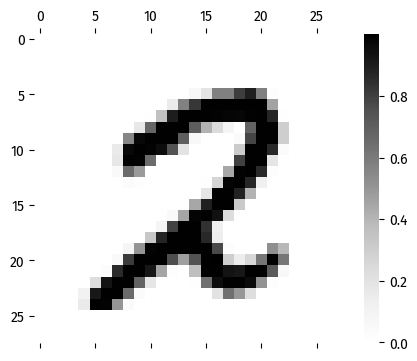

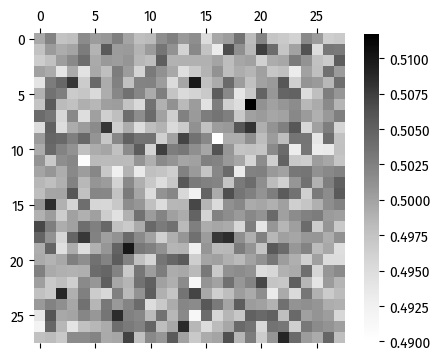

0.06026318 0.06120314
0.05952122 0.058965955
0.054675315 0.05431243
0.053330377 0.053840257
0.051202055 0.052244116
0.05218684 0.051942736
0.05114898 0.051225107
0.05219865 0.051456176
0.05016503 0.0503025
0.05005921 0.05058042
0.05113674 0.050780743
0.048325546 0.05014965
0.048645273 0.050234687
0.049237 0.050235838
0.04944815 0.050142948
0.049772806 0.050329413
0.049532183 0.050076157
0.050181314 0.050430086
0.050090387 0.05012565
0.04905971 0.05020488
0.048922807 0.050071307
0.0478106 0.050216895
0.050047375 0.05001112
0.050500534 0.050126135
0.05018062 0.05004652
0.04829128 0.05013219
0.04896467 0.050221726
0.049143426 0.05011963
0.049095664 0.049969215
0.049095206 0.050179794
0.049566403 0.049963873
0.04975303 0.050054602
0.04846208 0.049909253
0.04963365 0.04993723
0.049980313 0.050018083
0.049081575 0.050047647
0.049251094 0.050203193
0.05128907 0.05071267
0.04962326 0.050336454
0.049920008 0.05007133
0.049387142 0.04982177
0.049725715 0.049830023
0.049368232 0.050016563
0.04908

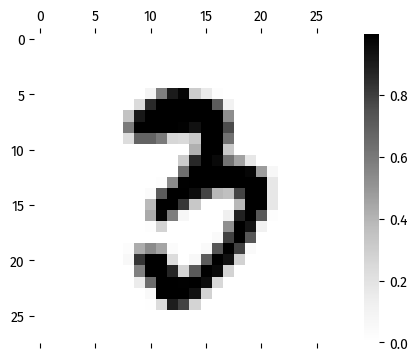

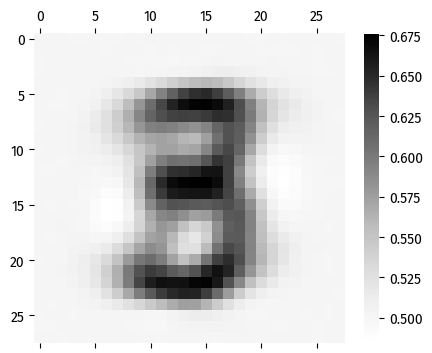

0.048046663 0.050133865
0.049946345 0.04987907
0.049847852 0.05004067
0.04838393 0.05006923
0.048393052 0.049777694
0.048991837 0.05005774
0.0497393 0.049828134
0.050425045 0.04981942
0.048006106 0.050115135
0.048803996 0.05011111
0.050895803 0.049901683
0.048389826 0.049874984
0.050787345 0.049855042
0.048604038 0.04991607
0.04946859 0.049953856
0.0500983 0.0500015
0.049119018 0.050043512
0.049621865 0.04983254
0.0492482 0.050033927
0.04912075 0.04999674
0.048316255 0.049800232
0.048354857 0.050000295
0.047696084 0.04976988
0.047311902 0.04978659
0.04914672 0.049874265
0.048433706 0.04982749
0.048266135 0.05003601
0.047712117 0.04977598
0.04836892 0.049903188
0.04876264 0.049862668
0.04999581 0.049956705
0.04876167 0.04985992
0.047628272 0.04991683
0.04862535 0.049747124
0.047743347 0.04984534
0.04814035 0.0497412
0.0492271 0.04987609
0.04878045 0.04990473
0.049735863 0.049847994
0.048695806 0.04983925
0.04997599 0.04996722
0.049148623 0.049884982
0.0492808 0.049880315
0.048956573 0.0

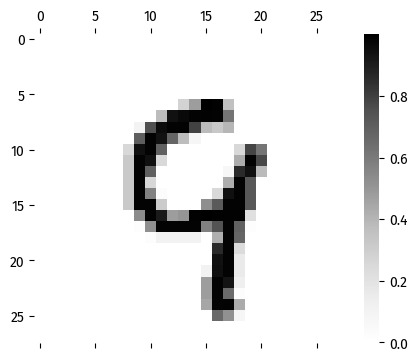

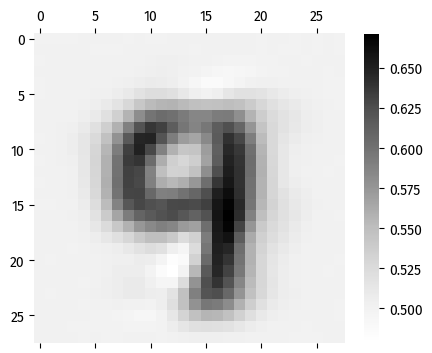

0.04849066 0.04995832
0.047971554 0.0499367
0.047902003 0.04987852
0.049704075 0.049936514
0.04900886 0.04991176
0.048378363 0.05000076
0.04960782 0.04999853
0.04889866 0.049893696
0.049107388 0.049777623
0.048396185 0.04984365
0.04792451 0.049918704
0.0489415 0.049921174
0.04792825 0.049924906
0.049398966 0.049829688
0.048927944 0.049862094
0.048898537 0.049768332
0.04842595 0.049860526
0.047391377 0.049853683
0.04729842 0.049987134
0.048743278 0.04988066
0.04962378 0.04987752
0.048384514 0.050061435
0.049947705 0.050001115
0.048396777 0.049918324
0.049823 0.04988049
0.048716024 0.049912278
0.0474957 0.049880236
0.049539562 0.049866367
0.049369797 0.0499504
0.04889987 0.0498447
0.047925685 0.049831327
0.04830776 0.049938187
0.048396066 0.04986196
0.049204126 0.04981189
0.04777769 0.049871333
0.04804053 0.04993781
0.049874537 0.049807455
0.048762992 0.049858905
0.049112618 0.050027404
0.049136348 0.04997293
0.05029255 0.049970567
0.0483649 0.049860958
0.0487577 0.049775302
0.048927687 

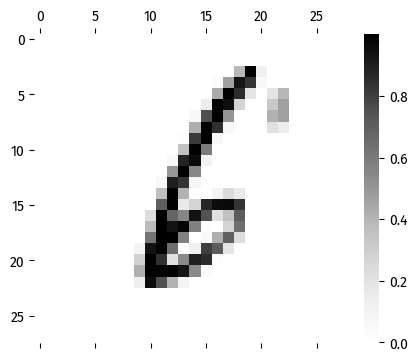

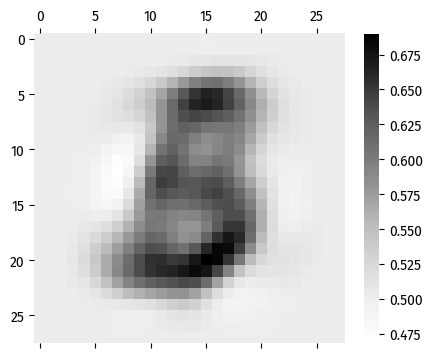

0.04828698 0.049882304
0.04997369 0.049829334
0.050434984 0.04989734
0.049405266 0.049935155
0.049530447 0.049821205
0.049978584 0.04986336
0.04775782 0.049900297
0.049340058 0.049843427
0.048623696 0.049981855
0.04881142 0.049973812
0.048827656 0.049926583
0.0489127 0.04990984
0.04864391 0.049867436
0.049269304 0.049865033
0.047046497 0.049894024
0.047654938 0.049840834
0.049871434 0.049999584
0.04791479 0.049950812
0.0497646 0.049972843
0.049367495 0.049910575
0.050886493 0.049853247
0.047882594 0.04988597
0.04893547 0.04991724
0.04832507 0.049836457
0.049021885 0.04982236
0.0500205 0.049908757
0.048440196 0.0498926
0.04914321 0.049918413
0.048800483 0.049889795
0.050119303 0.049882893
0.050399266 0.049900543
0.048817135 0.049913213
0.048257798 0.04982446
0.04822017 0.049933467
0.04688417 0.049988445
0.047420833 0.050023936
0.049136613 0.04993426
0.048378337 0.049965296
0.04749427 0.050003104
0.048354678 0.049868446
0.04844081 0.049901176
0.048177753 0.049849615
0.047469392 0.0500162

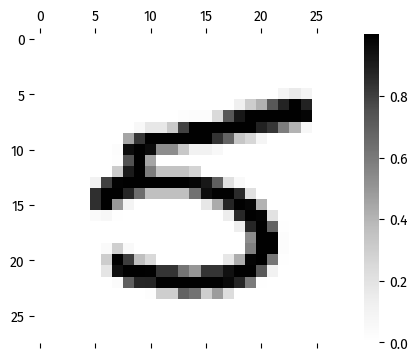

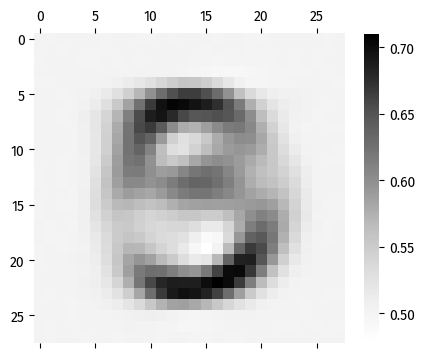

0.050135 0.049937867
0.05063919 0.049901795
0.04779453 0.04991636
0.049424715 0.049986485
0.05022434 0.049930535
0.048772722 0.049899485
0.04900086 0.049893085
0.048185673 0.05002327
0.04959967 0.049981873
0.04956662 0.049885448
0.046860695 0.049897183
0.048720624 0.049931433
0.048030976 0.049906876
0.04960922 0.049941797
0.04872869 0.049949937
0.049839556 0.049907252
0.049372755 0.050080717
0.050003726 0.049975995
0.05000194 0.049897216
0.048909273 0.050092895
0.04819148 0.04996073
0.051243618 0.04996259
0.048180684 0.04987677
0.049468834 0.049930137
0.046995327 0.04985661
0.048190355 0.049976345
0.04952274 0.049922843
0.048072144 0.049917053
0.049011968 0.049878452
0.048571974 0.049915697
0.04824286 0.049871545
0.049599405 0.049929883
0.04796284 0.04995383
0.04829591 0.049925994
0.048716217 0.050127428
0.047648437 0.049888577
0.048317812 0.049862113
0.047913652 0.050001085
0.048578568 0.050030317
0.049985625 0.049911488
0.046511546 0.04992919
0.04781037 0.050000843
0.048548933 0.0499

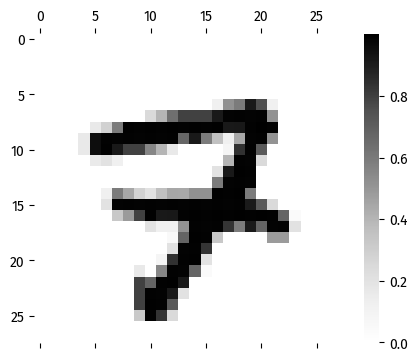

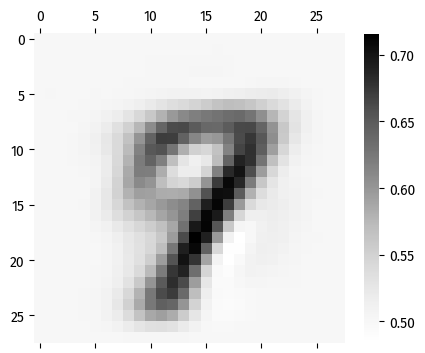

0.049802035 0.049996108
0.048048913 0.049976487
0.04886204 0.049957562
0.047549482 0.05014232
0.047099534 0.050002605
0.04936447 0.050003156
0.049249694 0.04996591
0.04796261 0.050047472
0.049313664 0.049997084
0.048451684 0.049960755
0.049378917 0.0499447
0.049590502 0.050035
0.04769937 0.049977448
0.04813809 0.04996114
0.04921862 0.049897123
0.048897643 0.049996927
0.048255175 0.04990575
0.050014947 0.049993157
0.048946552 0.049890537
0.04901886 0.049961735
0.050170474 0.05003431
0.048491992 0.050055154
0.047928408 0.04994715
0.050199393 0.049936447
0.049972285 0.0499391
0.049352027 0.049985334
0.04846913 0.049957305
0.048663974 0.050005533
0.05005349 0.050014228
0.048923187 0.049986906
0.049133226 0.04995794
0.047836974 0.049981322
0.050374288 0.049910218
0.050571878 0.049921215
0.048651483 0.049939696
0.049503252 0.049996044
0.04888227 0.049985565
0.04823822 0.0500475
0.047238052 0.04998401
0.048187174 0.049923148
0.048384912 0.049940083
0.04903848 0.050089758
0.049616143 0.0500012

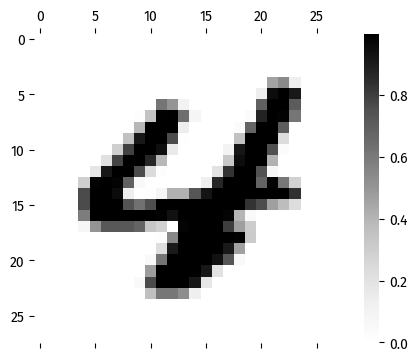

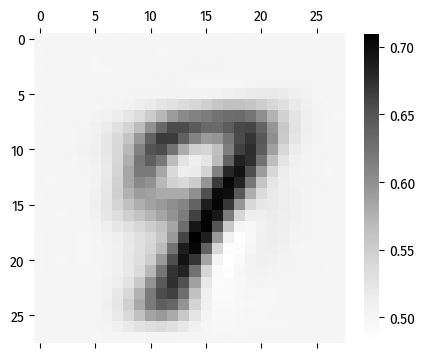

0.04794588 0.050038736
0.049181223 0.050001908
0.047872163 0.05003576
0.047454573 0.049972147
0.04761856 0.05000181
0.049457893 0.049982086
0.048071038 0.050001804
0.04740633 0.04991936
0.047994215 0.049929246
0.04830803 0.050047092
0.048482068 0.04998359
0.04823943 0.049958713
0.04753468 0.04995787
0.050590456 0.049971353
0.04897823 0.050053325
0.04875707 0.050041843
0.049141504 0.049964067
0.04922972 0.050015368
0.048784204 0.049985547
0.04804876 0.05002795
0.048938587 0.049989805
0.04820764 0.0499513
0.04856058 0.04997275
0.04839755 0.050036408
0.04836654 0.04998481
0.049127433 0.050078936
0.048260156 0.050013617
0.049678743 0.04996917
0.04718796 0.04996633
0.048894454 0.049956206
0.048631996 0.04997481
0.050470494 0.04997229
0.049954195 0.049899902
0.048822567 0.050017655
0.049266722 0.050030805
0.04855063 0.050023247
0.047826234 0.049960054
0.047777936 0.05007855
0.050107077 0.049919274
0.04882386 0.049961925
0.04942449 0.04992384
0.049298923 0.0499228
0.04898043 0.049975358
0.048

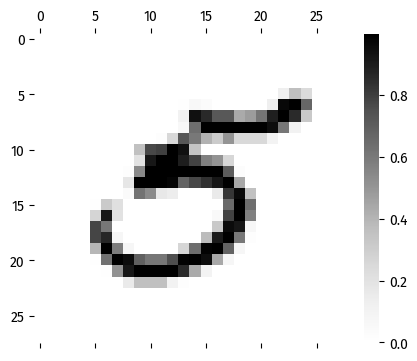

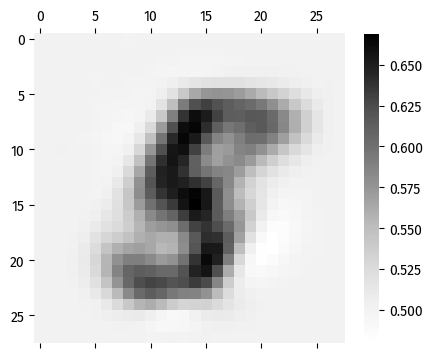

0.048166223 0.049997985
0.04716309 0.050100014
0.046479538 0.050044537
0.048599668 0.050017547
0.04842817 0.050084572
0.04905144 0.050037898
0.049392264 0.04993145
0.047434896 0.050075933
0.048260346 0.049996372
0.048527237 0.049989954
0.048067264 0.050103337
0.0488896 0.04998371
0.04818618 0.05002632
0.048126064 0.050081305
0.04807383 0.0499868
0.04778069 0.050024267
0.048036344 0.050113708
0.049354993 0.04996089
0.048537202 0.050014183
0.047955647 0.04999534
0.048806395 0.04999635
0.04812739 0.050010417
0.04934546 0.05004861
0.04867152 0.050003745
0.048500873 0.05005549
0.047541976 0.050021898
0.047062427 0.049972467
0.049157474 0.050082944
0.048985325 0.05004064
0.049435303 0.0500456
0.047997963 0.050008018
0.049270906 0.05004515
0.046069793 0.04999591
0.0475251 0.04998457
0.049149416 0.050038397
0.04709646 0.0500484
0.04816164 0.050046526
0.04911158 0.05015503
0.04781449 0.05007148
0.04802465 0.050035596
0.049805805 0.050045073
0.04838998 0.049977496
0.048233513 0.050011553
0.04816

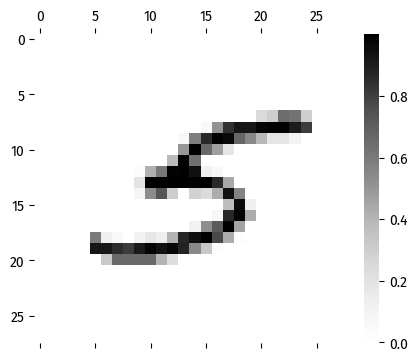

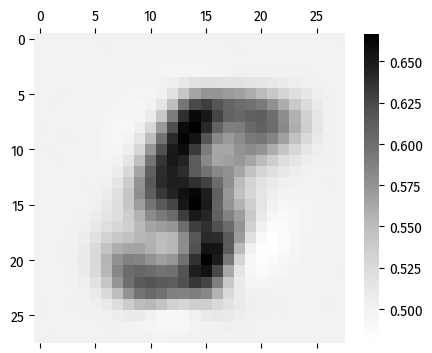

0.049251065 0.05002968
0.048205886 0.04996901
0.048839323 0.05004837
0.050209165 0.050013576
0.047222994 0.05001402
0.04769693 0.050076324
0.047694385 0.049985737
0.04768689 0.05001488
0.0495862 0.050003797
0.048424013 0.04999254
0.047828205 0.0500743
0.049462672 0.04999058
0.04858274 0.050031863
0.04861097 0.049985893
0.048634566 0.050054975
0.04962213 0.050067514
0.050812673 0.050058044
0.05020564 0.050117884
0.04847399 0.05012798
0.048024546 0.05015223
0.04835211 0.050136942
0.04880705 0.05003016
0.047669508 0.05002016
0.048766762 0.050048273
0.04895386 0.050030667
0.048301414 0.05003887
0.04896847 0.050069343
0.04846953 0.050033007
0.048258416 0.050070133
0.049533576 0.05002759
0.048420563 0.05009586
0.049135335 0.050027445
0.047810767 0.050059192
0.049895324 0.05003294
0.048686042 0.05004227
0.04892186 0.049984902
0.048856888 0.05002135
0.049614005 0.050095465
0.048962988 0.05003254
0.048570182 0.05008469
0.048503824 0.050034683
0.049364265 0.049993433
0.048798338 0.05005211
0.049

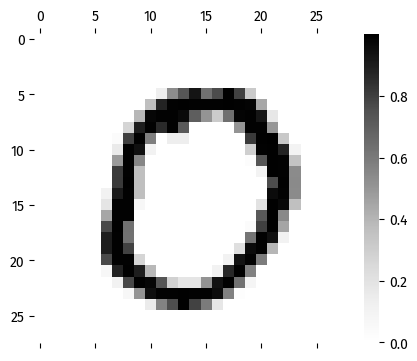

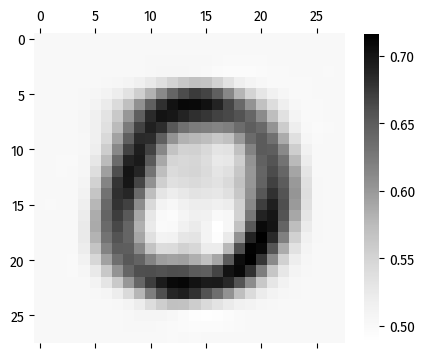

0.04866887 0.05003525
0.04859612 0.05006608
0.04917301 0.0500317
0.047795806 0.050056916
0.05091414 0.05004232
0.04976324 0.050060727
0.04880286 0.05010551
0.04883606 0.050135493
0.047557086 0.0500687
0.049732726 0.050113097
0.048049536 0.05008608
0.04997098 0.050068233
0.048130963 0.05004091
0.048664328 0.050053515
0.04827042 0.050023004
0.047940895 0.050071057
0.047362316 0.050021697
0.048977375 0.050147343
0.049272545 0.050030556
0.050447233 0.050071526
0.048992254 0.050032593
0.048520423 0.050097667
0.049424596 0.05005985
0.04793734 0.050023343
0.048554607 0.05006231
0.048767835 0.050043616
0.04870919 0.0500482
0.047487974 0.050115243
0.047982946 0.050130736
0.04946977 0.05007837
0.048813894 0.05005797
0.049044877 0.05008168
0.04755692 0.050054014
0.047871403 0.05001342
0.04886733 0.05003889
0.04798221 0.05006034
0.048067436 0.050064653
0.04747439 0.050121523
0.049024843 0.05004058
0.048029013 0.050099168
0.04742433 0.050045375
0.04726559 0.05008327
0.049195502 0.050036527
0.048147

/home/owner/Projects/picojam/jam/notebooks/../berries/plot_utils.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f, _ax = plt.subplots(figsize=(5, 5), dpi=dpi)


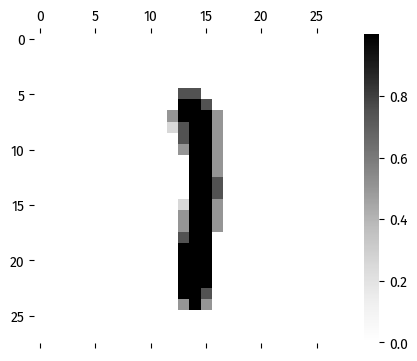

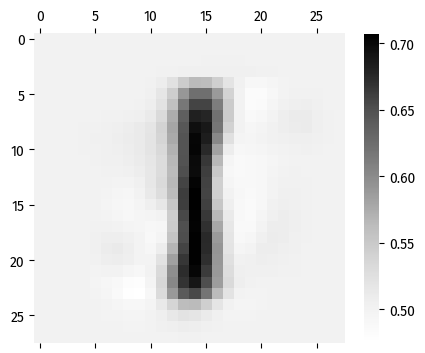

0.04901249 0.050135348
0.046922177 0.050014127
0.049382288 0.050080966
0.04911059 0.0500848
0.049195755 0.050048947
0.048257932 0.050067816
0.049214605 0.050142244
0.047367215 0.050063208
0.049529105 0.050056912
0.04944136 0.050084528
0.04783465 0.050041534
0.048482075 0.050083805
0.047969755 0.050203983
0.048190817 0.050093506
0.04734548 0.050070085
0.04871005 0.050126947
0.047936868 0.050060216
0.047899257 0.050102673
0.048923526 0.05012359
0.049304437 0.0500879
0.0480813 0.050126296
0.048985854 0.050157685
0.049339972 0.05012752
0.04839864 0.05006473
0.048007786 0.05004346
0.049021475 0.050072007
0.04761462 0.050106425
0.048148517 0.05007611
0.04745782 0.050109137
0.050596073 0.05011175
0.04894668 0.050108317
0.048431557 0.05006867
0.04732406 0.050104976
0.049978025 0.050158735
0.0493255 0.050089087
0.04920741 0.05012456
0.04749569 0.05010247
0.049814314 0.050086655
0.049178645 0.05002776
0.049716085 0.050054938
0.047731422 0.05006818
0.04906011 0.050078716
0.04920738 0.050056882
0.

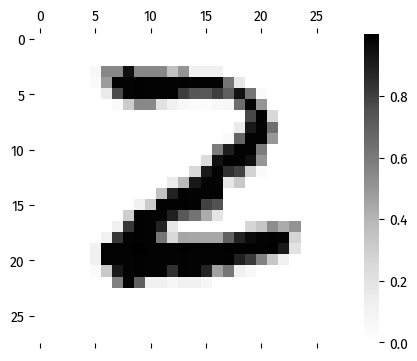

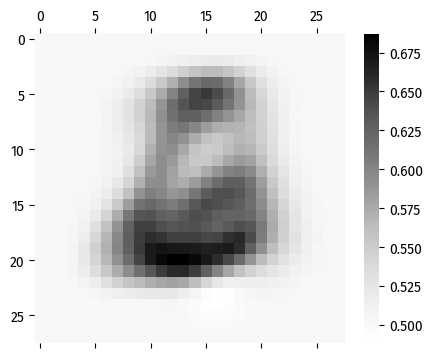

0.048259646 0.0501087
0.047957283 0.05009736
0.04897345 0.05008573
0.049142055 0.050102826
0.048353344 0.05009876
0.048180114 0.0501036
0.048326917 0.050106324
0.049196273 0.050081067
0.049426265 0.050081797
0.047347628 0.050112005
0.048612997 0.050124414
0.048290234 0.05014395
0.04803674 0.05006533
0.0481849 0.05007835
0.047804594 0.05018137
0.048973795 0.05008686
0.049389794 0.050089158
0.048743263 0.05007559
0.04883464 0.050055757
0.048118394 0.050069366
0.047987714 0.050091725
0.048683017 0.050078474
0.04795477 0.050101005
0.048369743 0.05006952
0.048841085 0.050170243
0.050949275 0.05007185
0.047642615 0.05013021
0.04874468 0.050150126
0.046251193 0.05013705
0.048775513 0.050164655
0.048192084 0.050215848
0.048756335 0.05015501
0.048953004 0.050085574
0.048702903 0.050083518
0.04878634 0.050080832
0.04894785 0.050124675
0.048225343 0.05007855
0.047926124 0.050137512
0.049004458 0.05014436
0.047249943 0.05011386
0.049468376 0.050080534
0.049238436 0.05012444
0.04830411 0.050090022


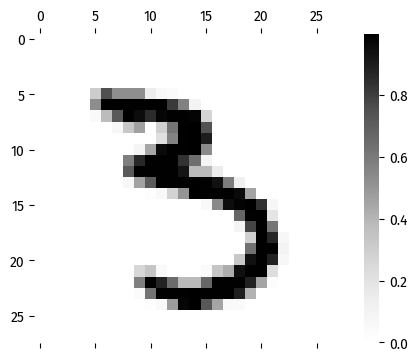

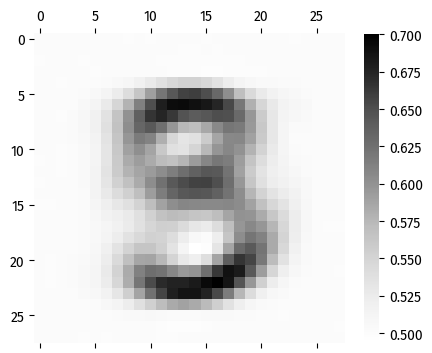

0.049024977 0.05011519
0.04833971 0.05008742
0.04797794 0.050132535
0.04816602 0.050085533
0.049026042 0.0500665
0.04814972 0.050072595
0.04946443 0.05013538
0.049911942 0.0501241
0.04739172 0.05010056
0.048246786 0.05010083
0.048613306 0.05015255
0.049078055 0.05016219
0.04931215 0.0500728
0.04941421 0.050077304
0.047792636 0.050156232
0.04859118 0.050065823
0.047215622 0.05011165
0.047859892 0.050174464
0.04685702 0.050088767
0.049062334 0.050095886
0.048631113 0.05012817
0.05058897 0.05008816
0.047311757 0.050092522
0.047444545 0.0501281
0.047653366 0.05013335
0.04917554 0.050103232
0.049486928 0.05014845
0.048417795 0.050126776
0.048063815 0.05014024
0.049307838 0.05013392
0.04885803 0.050128803
0.048718773 0.050134353
0.04788588 0.050117448
0.049252175 0.050066248
0.04859787 0.050134514
0.048863176 0.050148502
0.049351286 0.05010444
0.049353834 0.05013736
0.04955501 0.050118394
0.04805104 0.050094493
0.048134614 0.050137006
0.04770771 0.050106935
0.04867345 0.05013253
0.04891377 0

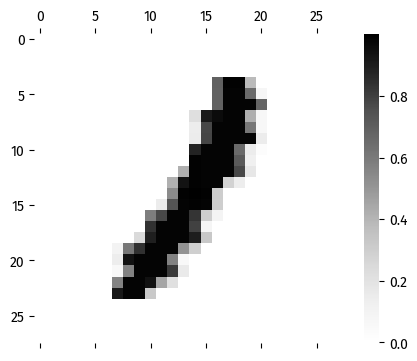

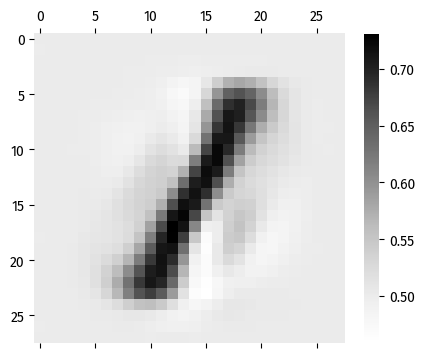

0.048382755 0.05012488
0.049324952 0.05007523
0.04837157 0.050099634
0.05057194 0.05010546
0.048436783 0.050098095
0.04917351 0.05006754
0.04951715 0.050119635
0.04942423 0.050102465
0.048355613 0.050107878
0.050159775 0.05008118
0.048556365 0.050106514
0.048320286 0.050153278
0.048758592 0.05015606
0.049609575 0.05016798
0.047556944 0.050132465
0.0489001 0.05015117
0.04864597 0.05012408
0.04889182 0.050184086
0.048048563 0.050112683
0.047288187 0.050114777
0.04935226 0.05009295
0.04844305 0.050114606
0.04899233 0.05013042
0.048052974 0.05015908
0.04824049 0.050161835
0.04833771 0.05012174
0.04896145 0.05015373
0.049128316 0.05018683
0.049059313 0.05015162
0.04811512 0.05021152
0.047720857 0.05012211
0.048184223 0.050098956
0.04837696 0.05013047
0.04861994 0.05012811
0.048129063 0.05010071
0.048921242 0.050142314
0.047267057 0.050149444
0.047401987 0.05009395
0.048295464 0.050113678
0.049528968 0.050086107
0.047929842 0.05008393
0.049113307 0.050088134
0.048309937 0.050122205
0.0490128

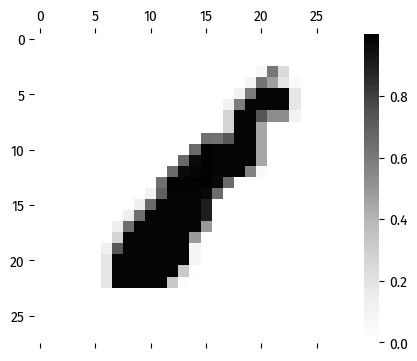

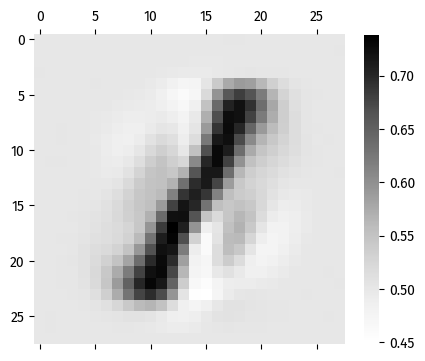

0.048965223 0.05013117
0.047594648 0.05014536
0.04791617 0.05013274
0.04926675 0.05011168
0.04904912 0.05015662
0.04931719 0.05012347
0.048859246 0.050136186
0.0482274 0.050129317
0.048736244 0.050123047
0.0488777 0.050181344
0.047952063 0.050135706
0.04839722 0.05009242
0.050050683 0.050107606
0.047889534 0.050153226
0.048646986 0.050092176
0.048039097 0.050129205
0.048472453 0.050150927
0.049755592 0.050107446
0.047417697 0.050148405
0.048323676 0.050109796
0.047059767 0.050143436
0.047988795 0.050116863
0.04792452 0.050162356
0.04934217 0.050209936
0.047999807 0.050176695
0.048153743 0.050147157
0.0488647 0.05015908
0.048604086 0.0501154
0.048618518 0.050161455
0.04901548 0.050172135
0.048035193 0.050210606
0.048692927 0.050129563
0.050051916 0.050161567
0.04864616 0.050126012
0.04908123 0.050187346
0.04880739 0.05013834
0.048794735 0.050126445
0.049216725 0.050200146
0.048590317 0.05011479
0.04907284 0.05016105
0.04926942 0.050110776
0.04971887 0.050146542
0.04917829 0.05016557
0.0

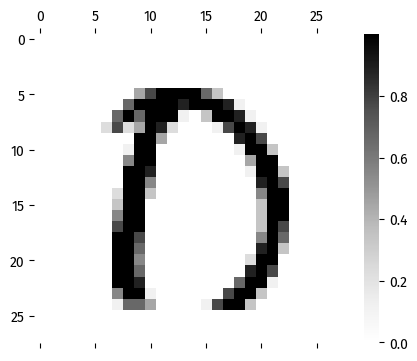

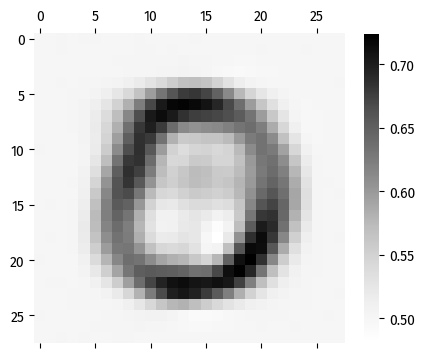

0.04909151 0.05016781
0.047638193 0.0501975
0.047537304 0.05023352
0.04912582 0.050159957
0.048888084 0.050107643
0.04845927 0.050176855
0.047074165 0.050166406
0.049741298 0.05014801
0.046478465 0.05020121
0.04979638 0.050185066
0.049541887 0.050125934
0.048786066 0.050179638
0.048635233 0.050107956
0.04874359 0.050187163
0.04726398 0.050239403
0.047695473 0.050189752
0.048962608 0.050182562
0.04765907 0.050171703
0.04925426 0.05020634
0.047423027 0.050152633
0.04882447 0.050183874
0.04788736 0.05016302
0.0476334 0.050148886
0.048104204 0.05019645
0.04824581 0.050180152
0.04729327 0.050147578
0.04751572 0.05019979
0.049411356 0.050205495
0.04922939 0.05015113
0.049655892 0.05023367
0.047194377 0.05019981
0.048625004 0.050208863
0.04877507 0.050211474
0.04983245 0.050208185
0.04763554 0.05018069
0.047851674 0.05017152
0.048482385 0.05015267
0.04880643 0.050172336
0.04786658 0.050163195
0.049455345 0.05016461
0.04718842 0.05017124
0.04823353 0.05011914
0.048894297 0.050165977
0.04904169

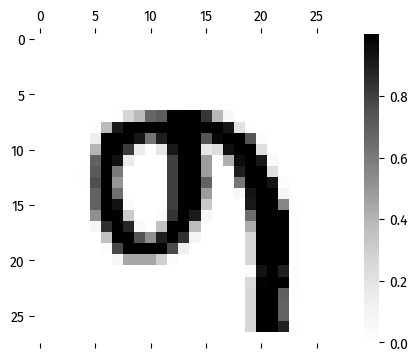

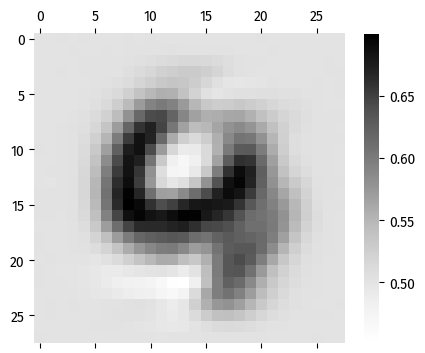

0.04918744 0.050157968
0.047785148 0.05017763
0.04875986 0.050131444
0.04960642 0.050133057
0.048454516 0.05018128
0.048964106 0.050192792
0.048999667 0.05017587
0.048159942 0.050154015
0.049504515 0.05020957
0.04723149 0.050193876
0.047829293 0.050265417
0.047727544 0.05026152
0.04862725 0.050170522
0.048308574 0.05015313
0.048610207 0.05018177
0.048518077 0.05014972
0.048521213 0.050181407
0.048167467 0.050162546
0.04977247 0.050138585
0.04965737 0.050128955
0.048133858 0.050166477
0.04887373 0.05014639
0.048658296 0.050207123
0.048291147 0.050198875
0.04833487 0.05021488
0.048525147 0.050219964
0.04818293 0.050207637
0.04893884 0.05019248
0.049671754 0.050151102
0.049592346 0.05015894
0.048895836 0.05014666
0.047633275 0.0502395
0.050313264 0.05015357
0.048982788 0.050179068
0.049598143 0.050245583
0.048112985 0.050181746
0.048757926 0.050202057
0.048656195 0.050164714
0.04886499 0.050173685
0.047520768 0.050180547
0.04882786 0.050158933
0.05043655 0.050144754
0.047551475 0.05018479

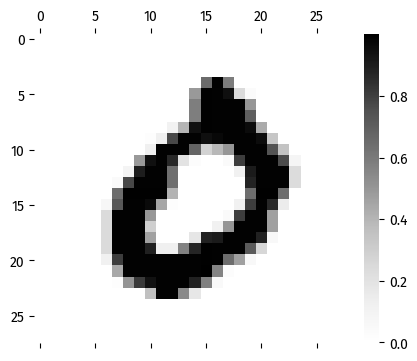

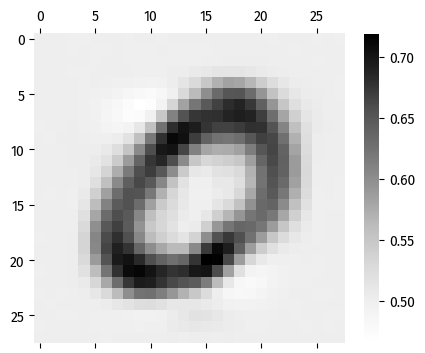

0.049229294 0.050176226
0.048870787 0.050209753
0.04750535 0.050147895
0.04829239 0.05018108
0.04809802 0.050228864
0.0483027 0.050205257
0.047533043 0.05019436
0.048486702 0.05023709
0.04929121 0.05019166
0.049285337 0.05020901
0.047635622 0.0501949
0.04947696 0.05023945
0.048763737 0.05019093
0.04950139 0.050204862
0.047217652 0.0502159
0.04645741 0.050252806
0.049152125 0.0502161
0.048396293 0.050220028
0.048653446 0.050178856
0.04931916 0.050195627
0.04913245 0.050211076
0.048693687 0.05022691
0.04810635 0.05025787
0.04804843 0.0502249
0.04882469 0.050239194
0.04778696 0.05017814
0.047890835 0.050225817
0.048425704 0.050168492
0.047946222 0.05023672
0.04742709 0.050241724
0.04893001 0.0501533
0.04746487 0.050210398
0.049486224 0.05021987
0.04841675 0.050257996
0.048553515 0.05019333
0.0480258 0.05021331
0.048627462 0.050230194
0.04798566 0.050162964
0.04888198 0.050282475
0.048285425 0.050226647
0.047782443 0.050177205
0.04855355 0.05020186
0.048777334 0.050223228
0.048072238 0.050

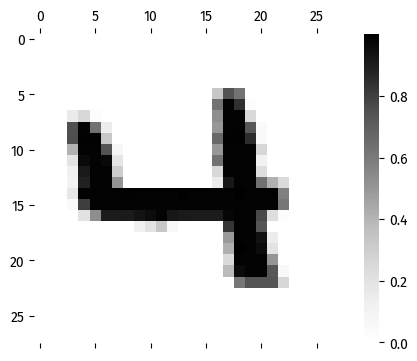

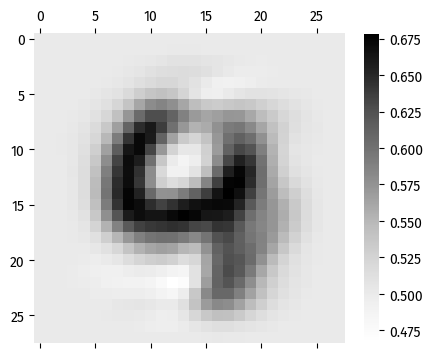

0.047176667 0.050223637
0.049298853 0.05021703
0.049101878 0.05018769
0.047799654 0.050208703
0.046915248 0.050227292
0.049215697 0.05021447
0.048259974 0.05018034
0.048928533 0.050202996
0.04881817 0.050198093
0.049594816 0.050233565
0.04891003 0.050242282
0.048540697 0.050261892
0.048499748 0.050215453
0.049129367 0.050240714
0.04840231 0.050196484
0.04831432 0.05022739
0.04836061 0.050219826
0.047910057 0.050223578
0.049018346 0.050245926
0.04800207 0.050235353
0.049802516 0.05024154
0.04907711 0.05023278
0.048173085 0.05017951
0.048859898 0.050216038
0.04842902 0.050198253
0.048129782 0.05020189
0.048760235 0.05020853
0.04898973 0.050191827
0.048387494 0.050179787
0.047868073 0.050192606
0.0477848 0.05023922
0.04848425 0.050230302
0.04845754 0.050187487
0.04763664 0.050169185
0.047913916 0.050249536
0.048350066 0.05023796
0.048896257 0.050206188
0.04864994 0.050213225
0.047777213 0.05020819
0.048956446 0.050304547
0.049283776 0.05028649
0.0485529 0.050173968
0.048634335 0.0502384
0

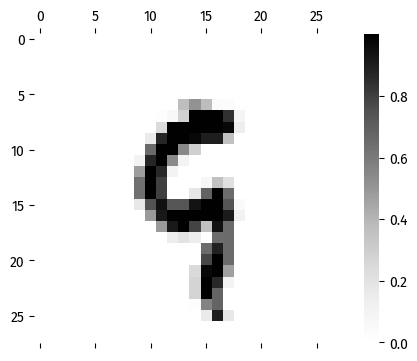

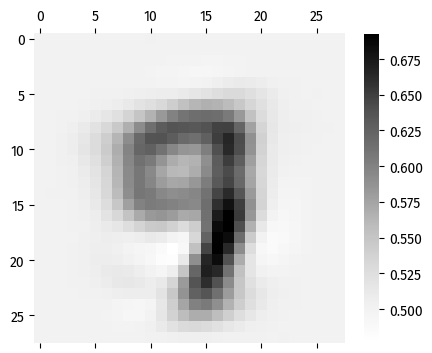

0.048385173 0.05015564
0.049386717 0.050283134
0.048484795 0.050237205
0.048958275 0.050159812
0.049088802 0.05023296
0.050225116 0.05020769
0.047830347 0.050255876
0.048877932 0.050229978
0.047514357 0.050254267
0.048469782 0.050210036
0.04964222 0.05021471
0.048436448 0.05018268
0.04833789 0.05024957
0.04794292 0.050222468
0.048649482 0.050267883
0.04784838 0.050218865
0.047271162 0.050241154
0.048296884 0.050204676
0.049398296 0.050237168
0.047659185 0.050259653
0.050143026 0.050214224
0.048685096 0.05026993
0.04772362 0.05027446
0.049399395 0.05023608
0.04936043 0.05022372
0.04743874 0.050250042
0.0486096 0.050197046
0.049396954 0.050199207
0.04977886 0.05021755
0.04925743 0.05024397
0.04760485 0.050279606
0.04899373 0.050258122
0.04715403 0.050265543
0.04856406 0.050260883
0.048675694 0.05025526
0.04818655 0.050187305
0.04826039 0.050226513
0.047923084 0.050230496
0.04801183 0.050218318
0.047620807 0.05023122
0.048392586 0.050200634
0.0488281 0.050215833
0.04876845 0.05020974
0.04

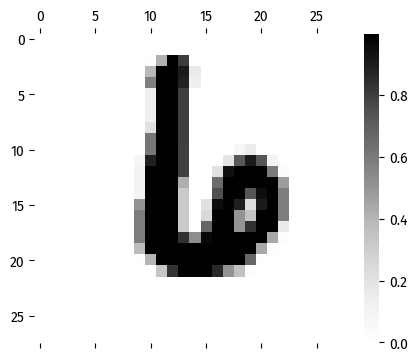

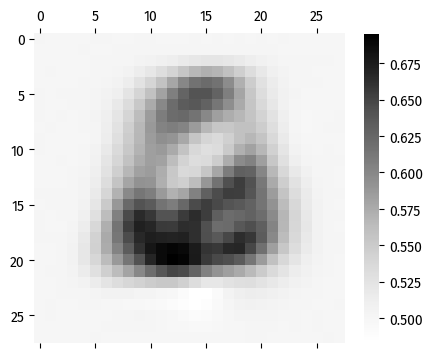

0.048669863 0.050197035
0.049101643 0.050246786
0.04735324 0.050221514
0.048120257 0.05022859
0.047603283 0.05024669
0.048816934 0.05026816
0.048691444 0.050243273
0.049530506 0.050254848
0.04853345 0.05020429
0.0473406 0.050251767
0.04834467 0.05019625
0.049411833 0.050268736
0.04915645 0.050222546
0.04818191 0.050251573
0.047666255 0.050213203
0.048435718 0.05022144
0.049507763 0.0502514
0.047265045 0.05019661
0.04753893 0.050250426
0.047797345 0.05020086
0.047742963 0.050256286
0.04871482 0.0502066
0.049081936 0.050264463
0.04864616 0.050293867
0.048245963 0.050241973
0.04803805 0.050245885
0.048352975 0.05024424
0.04697315 0.050241556
0.04898561 0.050256543
0.048361868 0.050237607
0.048488796 0.05024966
0.047678135 0.050232135
0.04921285 0.050180413
0.04902178 0.050223302
0.048632286 0.050229747
0.0487314 0.050250147
0.04901568 0.05026711
0.049051505 0.05026051
0.048923112 0.050240744
0.049491405 0.050255712
0.04820777 0.050268576
0.048325863 0.050276946
0.04836999 0.0502369
0.0496

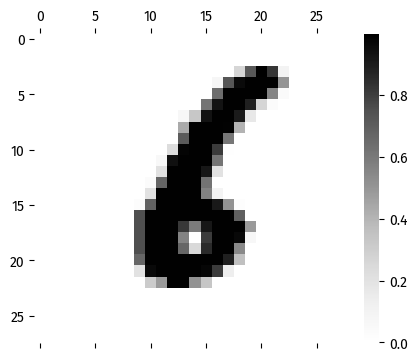

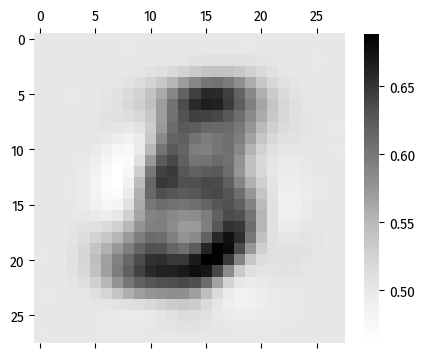

0.048080944 0.05025999
0.048493907 0.05022291
0.048226763 0.050220247
0.048480924 0.05022945
0.04857022 0.05021747
0.047202945 0.050287385
0.048466094 0.05025187
0.047785714 0.050259605
0.04895781 0.050227337
0.046250638 0.05026049
0.047750972 0.050224304
0.047469977 0.05025188
0.04743986 0.05028134
0.047912396 0.05030554
0.048584174 0.050252948
0.047461532 0.050257135
0.04812235 0.050284196
0.048581477 0.05028237
0.048078716 0.050249167
0.04815775 0.050269563
0.049764708 0.05024096
0.04775737 0.05023774
0.048319906 0.05025472
0.04819254 0.050210617
0.049544953 0.05026642
0.04787007 0.05023029
0.04928128 0.050277255
0.048246954 0.050245605
0.047216397 0.050291467
0.04799316 0.05023484
0.049251202 0.050266378
0.04959581 0.050232794
0.048554197 0.0502231
0.048892997 0.05028302
0.049033117 0.0502441
0.048054706 0.050259992
0.04891578 0.05026159
0.04910016 0.050322533
0.04827306 0.050249133
0.04818316 0.050267152
0.048869252 0.050255753
0.048398092 0.05029515
0.04931484 0.050264798
0.04903

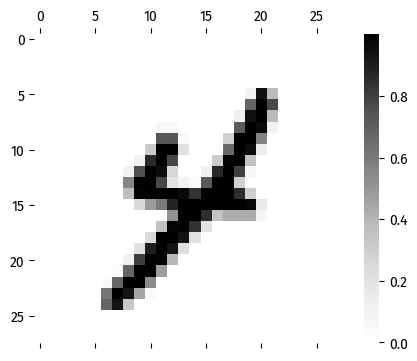

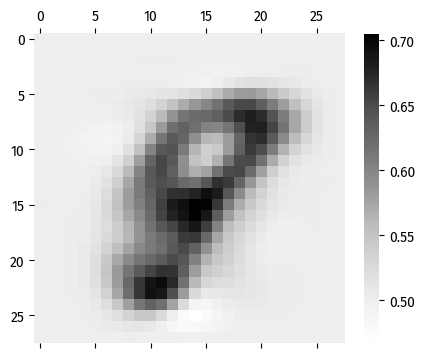

0.048783574 0.050305437
0.04869569 0.050220158
0.049692273 0.05029062
0.04856862 0.050267212
0.049725458 0.05026434
0.0496115 0.050259937
0.048225444 0.05026257
0.047699846 0.05023953
0.048116736 0.050254885
0.047816735 0.05021072
0.048565555 0.050297607
0.049404066 0.050277743
0.04957445 0.05025136
0.04985106 0.05024601
0.04920852 0.050253715
0.04760164 0.05026043
0.04978443 0.050275672
0.04893775 0.05025433
0.04942865 0.050278373
0.048837833 0.05027322
0.0480856 0.050284408
0.04832179 0.05029035
0.048893373 0.050266046
0.045801587 0.050282005
0.04920714 0.050265063
0.049215034 0.05024894
0.049088374 0.050256036
0.04825449 0.050258208
0.047543608 0.05022146
0.048255216 0.05023023
0.048118044 0.050314486
0.048507605 0.050318565
0.049785182 0.05028371
0.04846326 0.050307922
0.04771945 0.050318774
0.04907038 0.050261844
0.047989365 0.050288092
0.04848697 0.050285824
0.048597176 0.050298553
0.049600773 0.05025933
0.0480541 0.050229803
0.04834174 0.050308336
0.04804352 0.050267797
0.047515

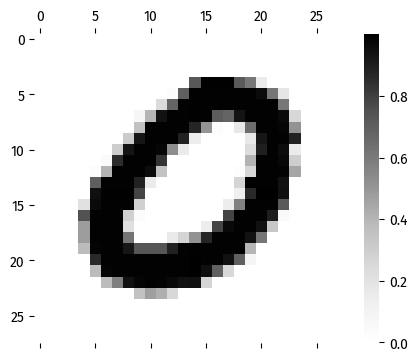

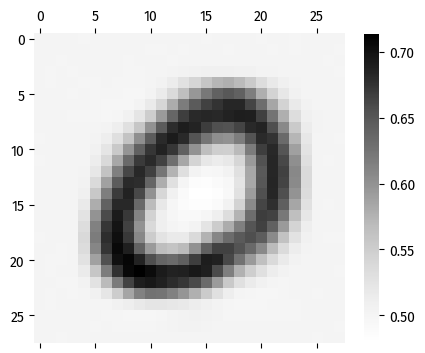

0.048799373 0.05025837
0.048602156 0.050295964
0.04918515 0.050292376
0.0487005 0.05026064
0.047596954 0.050279
0.047521345 0.05025374
0.048370466 0.05024973
0.046931565 0.05029167
0.04845932 0.050244644
0.047592055 0.050264716
0.049804263 0.050317574
0.050663047 0.050255395
0.047796223 0.05022744
0.049221627 0.050252456
0.047145147 0.050232816
0.047609948 0.050274458
0.050257362 0.05024594
0.048385225 0.050263353
0.04745298 0.05029396
0.048801426 0.050298054
0.04819756 0.050328992
0.04843213 0.050233252
0.0493214 0.050330736
0.04809326 0.05024558
0.047814574 0.05027768
0.048393387 0.05028742
0.04869673 0.050284736
0.049292378 0.050241057
0.048419982 0.050289884
0.04873444 0.05025133
0.049046323 0.05025705
0.049453653 0.050290775
0.049408093 0.05027567
0.049248107 0.050241545
0.049129978 0.050246455
0.047899064 0.050288256
0.04899411 0.050291386
0.04879542 0.05033743
0.048087638 0.050293475
0.049363755 0.05028382
0.04818438 0.05028482
0.048435375 0.050271038
0.047154326 0.050280154
0.0

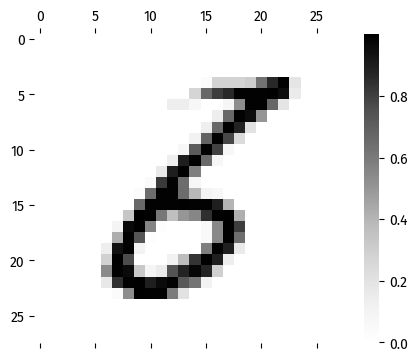

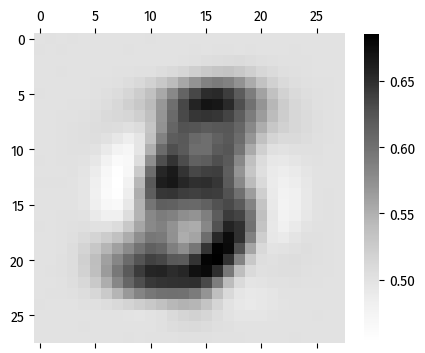

0.050235357 0.050335895
0.049654454 0.050284464
0.047033086 0.05033456
0.04878697 0.050277315
0.049478695 0.050315283
0.048616447 0.05030933
0.048861913 0.05024234
0.04802853 0.050296716
0.048154257 0.050294455
0.048413776 0.05029465
0.05018717 0.050330456
0.048718907 0.050267853
0.049723268 0.050347116
0.048433416 0.05030122
0.049575463 0.050310206
0.04853524 0.05024083
0.04717253 0.050284583
0.04762767 0.050298117
0.04897684 0.05027247
0.05012167 0.050253928
0.048025638 0.05027174
0.047712844 0.050266165
0.048949566 0.05031951
0.049651172 0.05027334
0.04749593 0.050288524
0.047790945 0.050272338
0.046663903 0.050308563
0.04806725 0.0502954
0.04813253 0.05024924
0.04978932 0.050309666
0.048841387 0.050241888
0.048194826 0.050306287
0.048176073 0.05027511
0.048399128 0.050224833
0.047624703 0.050252423
0.04874994 0.05029848
0.048273362 0.050343275
0.04814493 0.050266385
0.049034454 0.05037131
0.04985015 0.05028307
0.046987362 0.05025736
0.048172586 0.050279822
0.048821926 0.05027598
0.

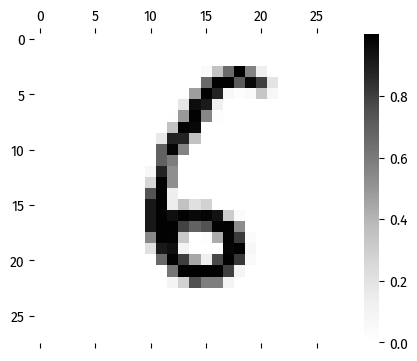

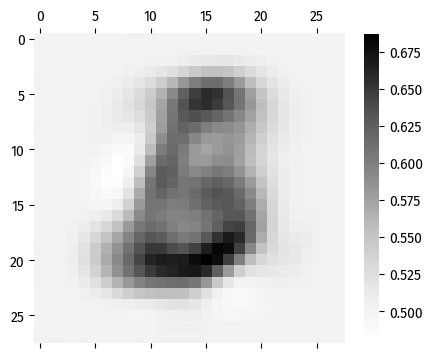

0.048699945 0.0502571
0.04765617 0.050281055
0.049322564 0.05029885
0.048912913 0.05030574
0.04841311 0.050304167
0.04817696 0.050328165
0.04880952 0.050276868
0.047523156 0.050323553
0.049111042 0.0502711
0.048462804 0.050290715
0.04961371 0.050303582
0.049015097 0.050294254
0.04802265 0.050316136
0.04821039 0.0503052
0.050179265 0.05031838
0.050177507 0.050332475
0.04795246 0.050319307
0.04807602 0.050295435
0.049847808 0.05030673
0.04806674 0.05024051
0.04982926 0.050302204
0.048148416 0.05028428
0.049104124 0.05024445
0.048603926 0.050258305
0.04793746 0.05035891
0.048101768 0.050291356
0.049451485 0.050304245
0.048250526 0.050291747
0.04750239 0.05028784
0.048131604 0.050295465
0.049195968 0.050279867
0.048892215 0.0502915
0.04782218 0.050279416
0.04765095 0.050297573
0.04856042 0.050298028
0.047781393 0.050276723
0.047955886 0.050242778
0.0502111 0.050270256
0.048626408 0.050258238
0.049144924 0.050294835
0.04697035 0.05027334
0.04766622 0.050334185
0.04940249 0.050312657
0.04806

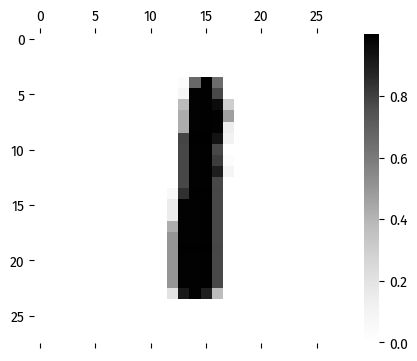

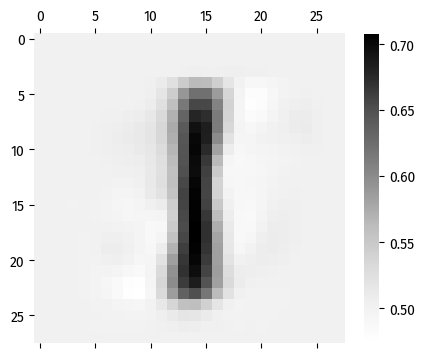

0.048950218 0.05028641
0.048567705 0.05030865
0.04854933 0.050273217
0.048823748 0.05031193
0.049786303 0.050300796
0.048748277 0.050336603
0.048621103 0.050327804
0.047698393 0.050306253
0.04940021 0.050273366
0.048346538 0.050255787
0.048872102 0.050300647
0.049215768 0.050307073
0.047787704 0.050340667
0.048198152 0.050297886
0.04785212 0.050349858
0.049307182 0.050314184
0.047710627 0.050281435
0.04925795 0.050292406
0.049071576 0.05035659
0.04848884 0.050301403
0.05021087 0.050321124
0.048941456 0.050289694
0.049545072 0.05032929
0.048733167 0.050323304
0.048229937 0.050291162
0.0500744 0.050337315
0.04832228 0.050288003
0.048174378 0.05030662
0.047921754 0.050300702
0.0485607 0.050282434
0.048522692 0.05031242
0.048655257 0.05031603
0.04830607 0.050298844
0.04900246 0.050314885
0.0484972 0.050373472
0.048861884 0.050342944
0.049870104 0.050199892
0.047833636 0.050076727
0.04888404 0.05033869
0.04872402 0.05013454
0.048347935 0.0500802
0.048274092 0.050059747
0.047442563 0.0500070

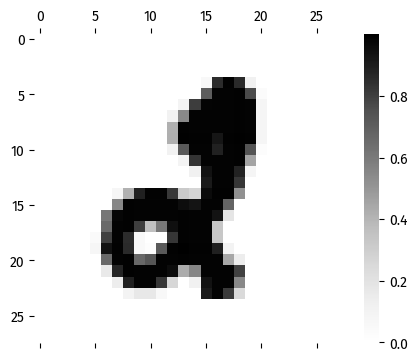

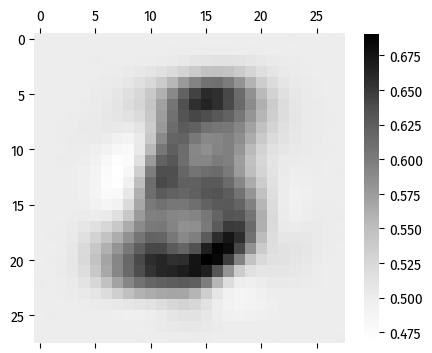

0.04871016 0.050072275
0.049352407 0.050073724
0.04961098 0.05010134
0.04919733 0.050181177
0.048157386 0.05004268
0.049211435 0.05009092
0.048751213 0.050208084
0.048670832 0.050125346
0.04983458 0.05052176
0.04886031 0.050039966
0.047845706 0.0500888
0.048050363 0.050026953
0.04868948 0.0500828
0.0482615 0.050066516
0.047778174 0.05008499
0.047997706 0.050049327
0.0496904 0.05010044
0.048168845 0.050055943
0.047574557 0.05015205
0.048433054 0.050130382
0.04840207 0.05012698
0.046577998 0.050160527
0.0480325 0.05015354
0.047831796 0.050138544
0.049036026 0.05017426
0.04937528 0.050179426
0.046905085 0.050195068
0.04814332 0.050225623
0.048456803 0.050171167
0.04917942 0.050183576
0.047997497 0.05018706
0.048458423 0.050258633
0.04795093 0.050194945
0.048463345 0.050202727
0.046156757 0.0501838
0.0483016 0.05018555
0.048220064 0.05020758
0.05020397 0.05005614
0.048280306 0.050125685
0.048380718 0.050146464
0.049454127 0.05014479
0.048902184 0.05019264
0.04829686 0.050210983
0.04988021 

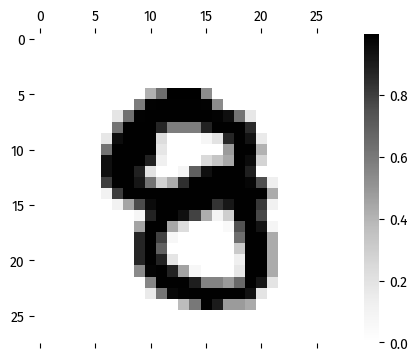

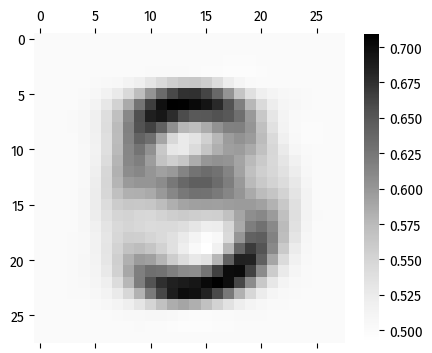

0.048384063 0.050202783
0.048018597 0.050206896
0.04834145 0.05023774
0.048446685 0.05022168
0.048074096 0.05019031
0.047103204 0.050248876
0.047640476 0.05018083
0.048004642 0.05019269
0.04729084 0.050209716
0.04861643 0.05018609
0.048211522 0.050234254
0.048183806 0.05022206
0.048464406 0.050203763
0.04833307 0.05024159
0.04772824 0.05023491
0.048814088 0.050225303
0.048023805 0.050256968
0.04791001 0.050237224
0.048650485 0.05024878
0.048185926 0.050261788
0.049220294 0.050261382
0.048494484 0.050211698
0.047828645 0.050326273
0.048914492 0.05028566
0.050364785 0.050238013
0.047114607 0.050308753
0.04833451 0.050207283
0.04860576 0.05025568
0.04926844 0.050282247
0.04818145 0.050269708
0.049029715 0.05025086
0.049001917 0.05025479
0.048579317 0.050244056
0.047872834 0.050243884
0.048955753 0.050239507
0.049366415 0.050244898
0.048321307 0.05025425
0.049025234 0.050252654
0.047534846 0.050272655
0.048330475 0.050272755
0.047306113 0.05025318
0.04881721 0.05028119
0.04907745 0.0502910

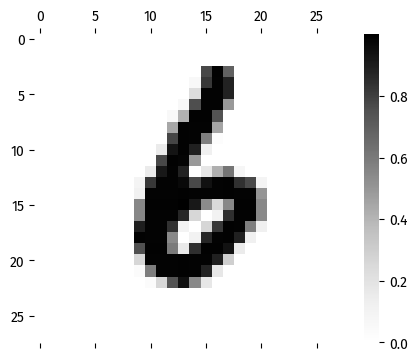

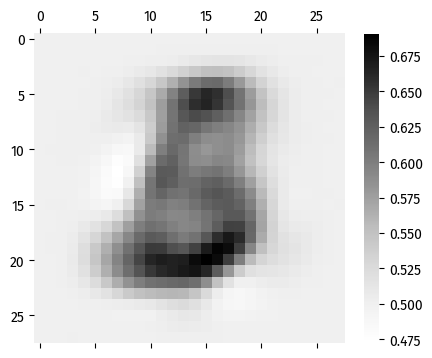

0.04931897 0.05025974
0.046816096 0.05024289
0.049062453 0.05026387
0.048778556 0.050263576
0.048089348 0.050281372
0.050988674 0.05025362
0.04744528 0.050291844
0.048111007 0.050252084
0.049709935 0.050282724
0.04927885 0.050279655
0.048450142 0.05021896
0.048585407 0.050248433
0.04976839 0.050247665
0.04830311 0.050253425
0.04791131 0.050253548
0.05030973 0.050260454
0.048922613 0.05025013
0.049184255 0.050277025
0.047673393 0.050291486
0.048316002 0.05025862
0.048175294 0.05027097
0.048298247 0.050249077
0.047959935 0.050299797
0.047756545 0.050262567
0.04756582 0.050313536
0.048404746 0.050254405
0.04752769 0.050295774
0.04759845 0.05025346
0.047816604 0.0503232
0.047780417 0.0502503
0.049572285 0.050279774
0.047518745 0.050249726
0.04983131 0.050242648
0.04952155 0.050267685
0.049348325 0.05027109
0.04915203 0.05028988
0.049138956 0.050279718
0.049570043 0.05026885
0.04895632 0.05030145
0.04876801 0.050302587
0.048310958 0.050245848
0.04812209 0.050246906
0.04893841 0.05028444
0.0

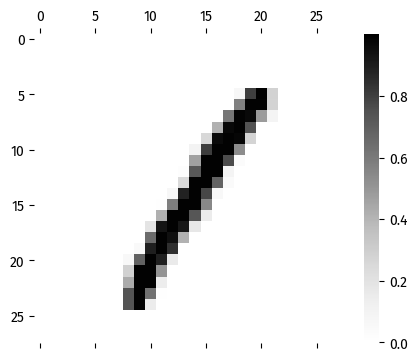

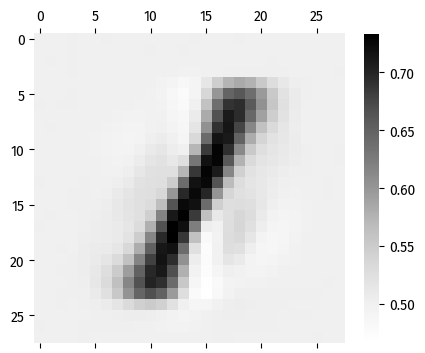

0.047079153 0.050285712
0.049022153 0.050313354
0.049021 0.050314397
0.04730572 0.050357852
0.048625104 0.05026637
0.049200147 0.050256547
0.0493477 0.050258294
0.04831416 0.050278258
0.047583807 0.05029634
0.04807717 0.05025679
0.04861571 0.05028361
0.04754716 0.050316516
0.048478454 0.05030395
0.048466753 0.050329372
0.04886145 0.050302457
0.047956653 0.05030215
0.048157573 0.050309107
0.047860324 0.050285097
0.049386784 0.05029335
0.047438107 0.05028757
0.048030123 0.050304126
0.049578957 0.050290838
0.048579097 0.05030581
0.04869722 0.050298624
0.049235612 0.050279837
0.049089987 0.050316576
0.048139326 0.05031357
0.04939076 0.050290845
0.047681116 0.050298724
0.04896657 0.050301377
0.048130296 0.05034721
0.047861606 0.050289568
0.048210014 0.050337277
0.050014272 0.050298896
0.04887431 0.05025921
0.048992537 0.050374903
0.048484273 0.050287265
0.048656665 0.050352436
0.04804327 0.05027864
0.04882055 0.05031067
0.049601905 0.050307103
0.048740998 0.050315466
0.04821222 0.050311185


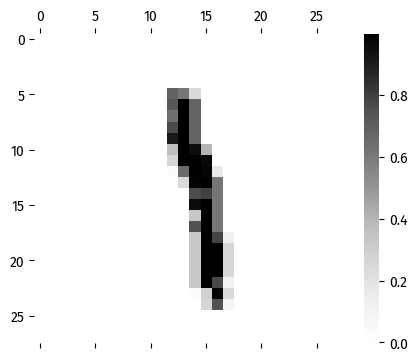

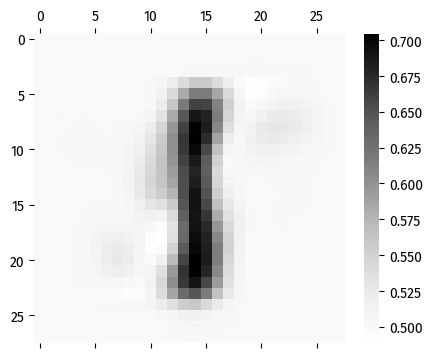

0.047225162 0.050301593
0.048630975 0.050289843
0.048503846 0.050286233
0.04820516 0.050301697
0.049780525 0.05029645
0.048444778 0.050307
0.050290998 0.050295923
0.047635853 0.05029827
0.047556125 0.05030866
0.047600605 0.050251987
0.050184786 0.050290655
0.04915476 0.050304987
0.049564715 0.050298844
0.04849169 0.050295528
0.04751553 0.050276678
0.048171557 0.050288558
0.048694164 0.0503228
0.048698083 0.050304826
0.049185477 0.050310828
0.048953097 0.050314747
0.047531277 0.050290287
0.047668815 0.050290734
0.050667137 0.050282635
0.047824375 0.050299358
0.048636597 0.050353155
0.04788724 0.050295323
0.048256256 0.050314695
0.049301967 0.050346166
0.04780215 0.05034024
0.047905616 0.05031413
0.04815682 0.050371014
0.04864768 0.05033435
0.049018756 0.05031691
0.050267864 0.050313074
0.04849057 0.050299376
0.049168117 0.05031817
0.047687463 0.050273642
0.049293287 0.050301813
0.048517033 0.05031814
0.048869457 0.05031308
0.04827185 0.05030436
0.04810156 0.0503506
0.048793107 0.0503076

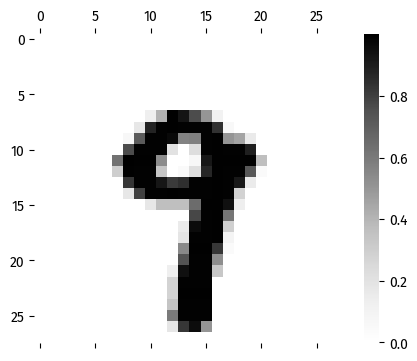

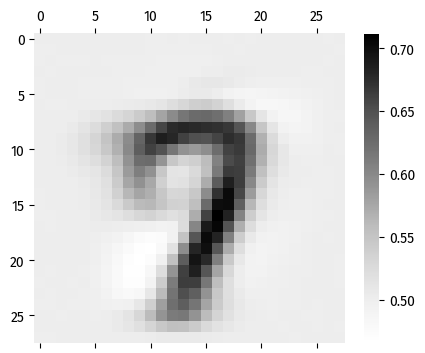

0.04941027 0.050322317
0.048903476 0.05032246
0.047832392 0.05037721
0.048035637 0.050283644
0.04853969 0.050323322
0.04895728 0.05033456
0.04782867 0.050341584
0.048839502 0.05031169
0.049248382 0.050312076
0.048874795 0.05033789
0.048523404 0.05036367
0.048146978 0.050319914
0.048794746 0.050301317
0.048719995 0.05029513
0.048195504 0.050296146
0.049565084 0.050310086
0.047419064 0.050319586
0.047689468 0.050300963
0.046857078 0.050313555
0.049631085 0.05031285
0.048473105 0.05030479
0.048699033 0.050305746
0.047646746 0.05029976
0.048651434 0.050363068
0.048665192 0.050316785
0.047464788 0.050338916
0.049685247 0.050330933
0.04799994 0.050372086
0.047663383 0.050317384
0.047889404 0.050363526
0.049028583 0.05031313
0.048718225 0.05031594
0.048189446 0.050293148
0.047245376 0.050321292
0.04887788 0.05031947
0.049313344 0.050348397
0.047571942 0.050318114
0.048715945 0.05038304
0.04693703 0.05035348
0.048358772 0.050349005
0.050124995 0.050315488
0.04917018 0.050352722
0.049493074 0.0

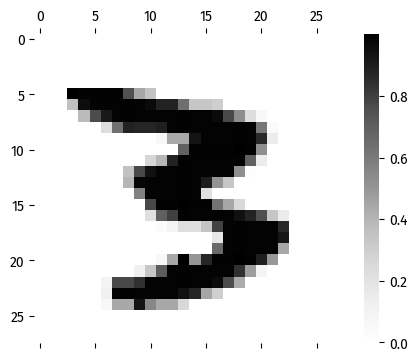

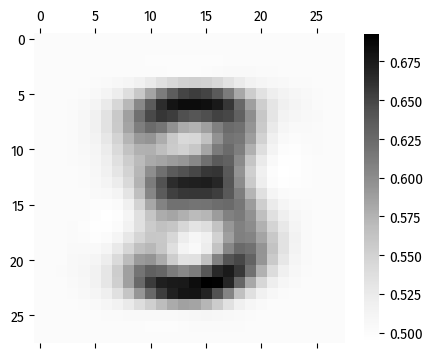

0.049088333 0.050319206
0.04838571 0.050340552
0.04879687 0.050306704
0.048896335 0.05032654
0.04736393 0.050348453
0.049023136 0.05031209
0.048450984 0.050315488
0.047650993 0.050331365
0.045991197 0.050355926
0.04848531 0.050343376
0.04859537 0.050290614
0.04859283 0.05034494
0.04886871 0.050324224
0.048755616 0.050343405
0.04909449 0.050338868
0.048520654 0.050335284
0.047837578 0.050313823
0.047792364 0.050318927
0.04840246 0.050343547
0.0484201 0.050332583
0.048436716 0.05035675
0.04792943 0.050358567
0.048837192 0.050369542
0.048998114 0.050365582
0.04969335 0.050360903
0.047929965 0.050340027
0.048334505 0.050359245
0.047986455 0.050368063
0.048107427 0.050321832
0.048066862 0.050340638
0.047336843 0.050342035
0.047629043 0.050314955
0.04849578 0.05034961
0.04864666 0.050323863
0.04764404 0.050343733
0.047710434 0.050339375
0.048275806 0.050324433
0.048681967 0.05031837
0.048181903 0.050329264
0.04824205 0.05037261
0.04773598 0.050370604
0.049009934 0.05036004
0.048324533 0.0503

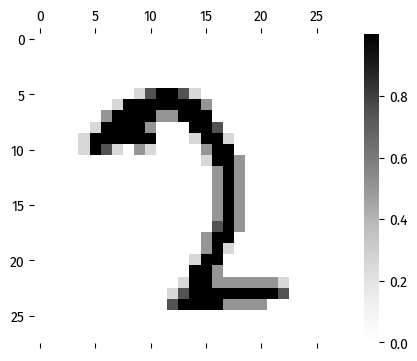

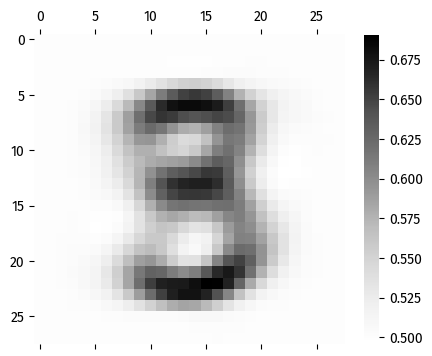

0.04807177 0.05037618
0.049612697 0.050402332
0.050289553 0.050358463
0.04632789 0.0503416
0.047984466 0.050347466
0.048141368 0.050328832
0.049559176 0.050334528
0.048838783 0.050348964
0.047621302 0.0503826
0.04957279 0.05032324
0.049039714 0.05038218
0.048004817 0.050353985
0.04802665 0.050344665
0.048064154 0.050412256
0.049085252 0.05032052
0.0483196 0.050338
0.049207512 0.050331794
0.048829515 0.050329547
0.049354352 0.050324026
0.048561014 0.050354257
0.04782797 0.05034712
0.048235428 0.050316844
0.048851576 0.050340064
0.048935503 0.050357036
0.049160063 0.05034099
0.04948985 0.050328493
0.04934897 0.05033949
0.04796991 0.050330203
0.04744839 0.05033674
0.048766844 0.05039377
0.048030842 0.0503245
0.04830376 0.05037746
0.048848573 0.05036182
0.0492519 0.050339285
0.049306154 0.050386712
0.04949985 0.050327193
0.047247738 0.05035526
0.04918815 0.050349638
0.048867814 0.05030541
0.048086528 0.050348874
0.048510697 0.05034806
0.048108406 0.050360966
0.049576 0.050372843
0.04840627

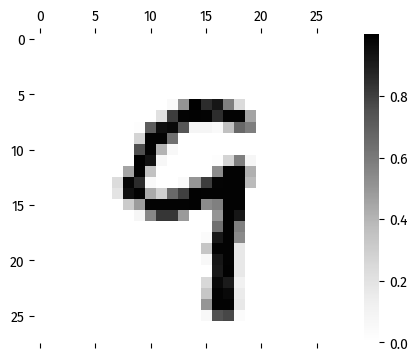

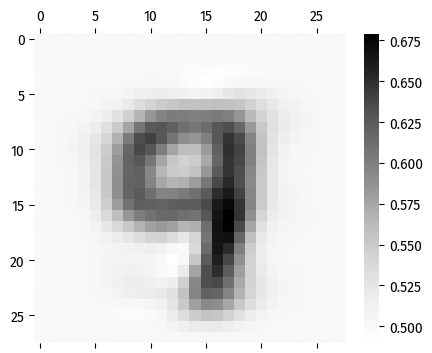

0.048913658 0.05032332
0.04875814 0.05033873
0.047648042 0.050315086
0.04811485 0.05033718
0.046523683 0.05034776
0.048356228 0.050354723
0.04948588 0.050369263
0.0480932 0.050374754
0.049071155 0.050333623
0.04858751 0.050375123
0.047786146 0.050328344
0.048699126 0.050365686
0.047925718 0.050342258
0.048506636 0.050335076
0.049648665 0.050368167
0.048749823 0.05037142
0.04682096 0.05039742
0.048568532 0.050360728
0.048442923 0.05037962
0.047502108 0.050368827
0.04894963 0.050379984
0.04863063 0.050361246
0.048980847 0.05035877
0.047916725 0.050373908
0.049199514 0.050366372
0.047826193 0.050333094
0.04833164 0.050369415
0.04901962 0.05035912
0.048207924 0.050343867
0.047616757 0.050342895
0.047267392 0.05035956
0.04736736 0.05036919
0.048115037 0.050371733
0.048105113 0.05037652
0.047468778 0.05041969
0.048231237 0.050369583
0.04720471 0.050396044
0.048021108 0.05042934
0.048050128 0.050374933
0.049517788 0.050413284
0.048432693 0.050401397
0.048944883 0.05035053
0.049195513 0.050411

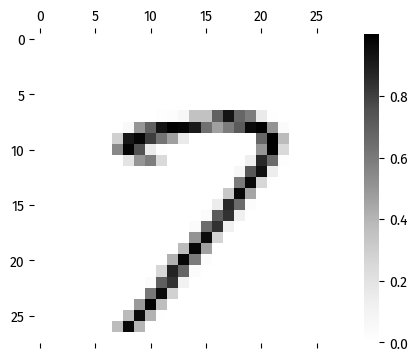

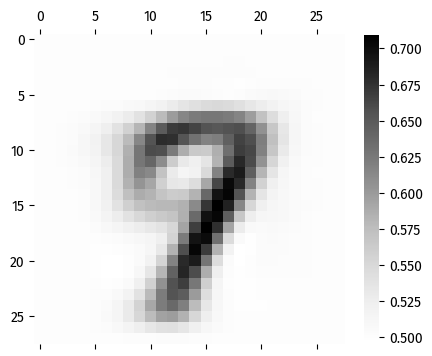

0.04905596 0.05035725
0.048743587 0.050401133
0.048715774 0.050350048
0.04864246 0.050373394
0.048868977 0.050355658
0.047628034 0.05033752
0.049720455 0.05037179
0.048437994 0.050354138
0.049137883 0.05037012
0.048524488 0.050392795
0.049673192 0.05037195
0.048168033 0.050458007
0.0490653 0.05042483
0.048417013 0.05037765
0.047286566 0.0503306
0.04880236 0.050421897
0.048511736 0.050376456
0.050087795 0.05041434
0.047521032 0.050413463
0.047663324 0.050355762
0.048336655 0.050380304
0.049187806 0.050383728
0.048489608 0.050402462
0.04868951 0.050377857
0.047455758 0.050352436
0.047907222 0.050346967
0.04893554 0.050384182
0.048921265 0.05036864
0.048352618 0.05036799
0.049962834 0.050383758
0.047755063 0.050384887
0.048693553 0.05036957
0.048384864 0.050401676
0.048393063 0.050389424
0.04923641 0.050375484
0.04793149 0.050387494
0.04796638 0.050401267
0.04769609 0.05038494
0.047089618 0.050330434
0.04901752 0.050379194
0.048423402 0.0504197
0.047834523 0.050363425
0.04779669 0.0503702

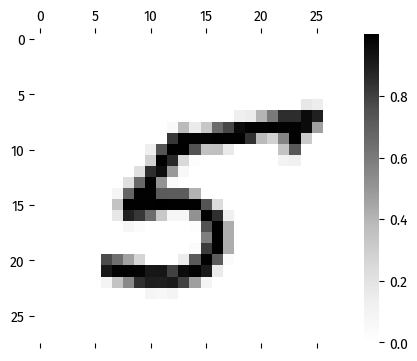

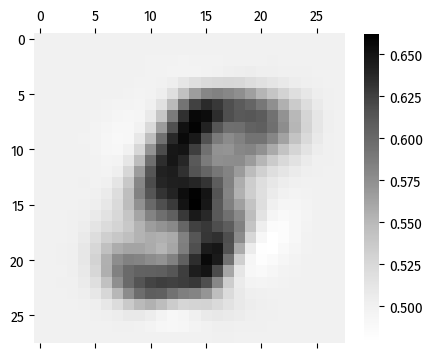

0.047755063 0.050416406
0.049120627 0.050380558
0.04940304 0.05039757
0.047872525 0.050375115
0.04858601 0.05040649
0.048547115 0.050340317
0.049235143 0.050374083
0.04892759 0.05039071
0.048407625 0.05041942
0.048886366 0.05037765
0.04791233 0.050395038
0.048885256 0.050376955
0.048740804 0.050354507
0.049646787 0.05036356
0.048616987 0.050362326
0.04866007 0.050379638
0.04795652 0.050379176
0.047964018 0.050403193
0.04777942 0.050430655
0.049158014 0.050410032
0.049434386 0.05038791
0.048482187 0.050357487
0.048854496 0.050401453
0.046768777 0.050409503
0.048616998 0.050361954
0.048515465 0.050430056
0.048262857 0.050385598
0.04849101 0.050370127
0.049254872 0.050349962
0.04920453 0.050396033
0.048150085 0.050406802
0.049254987 0.05038889
0.04850736 0.05038162
0.049334846 0.050389
0.04847738 0.050381605
0.048917137 0.050390903
0.049265802 0.050365806
0.049401116 0.050375775
0.048672795 0.050364047
0.047585506 0.050418273
0.04729104 0.050365146
0.047036055 0.050357994
0.048212312 0.05

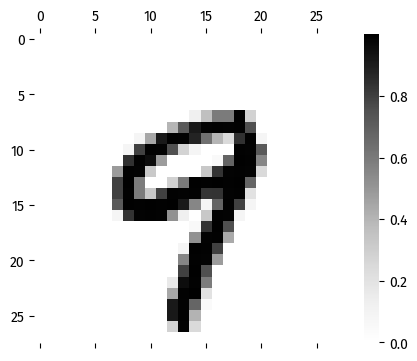

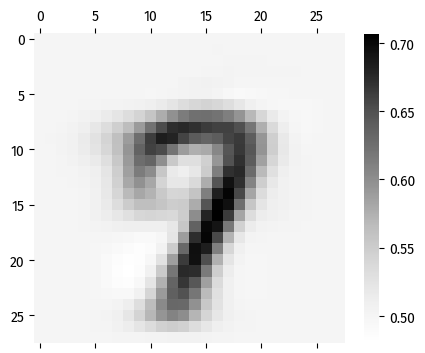

0.049783442 0.05036486
0.048315015 0.050376218
0.049063034 0.050370064
0.049209505 0.050358504
0.04869476 0.05042424
0.04878209 0.05038148
0.047886185 0.050345547
0.047670104 0.050406896
0.04759731 0.05044787
0.04833658 0.05041639
0.049165543 0.05037498
0.04830957 0.050428122
0.048993833 0.05043794
0.04816337 0.05038809
0.048379205 0.050427362
0.048539672 0.050419804
0.048358597 0.05041336
0.049925514 0.05037061
0.0488683 0.05040803
0.04956325 0.050396204
0.04812342 0.050428674
0.04845857 0.050395004
0.04765887 0.050428286
0.049370386 0.05038497
0.04905427 0.05038723
0.046903547 0.050445177
0.048209637 0.050388187
0.048727952 0.050397452
0.04782386 0.050401177
0.047987208 0.05041494
0.048430897 0.050414905
0.047776528 0.05037893
0.049638472 0.05037374
0.04746849 0.050434142
0.048066292 0.05039018
0.04816707 0.050410327
0.048250988 0.050396405
0.04880029 0.050423685
0.04718294 0.050424602
0.049409203 0.050395407
0.048299897 0.050420612
0.047755282 0.050412964
0.04881843 0.05039995
0.049

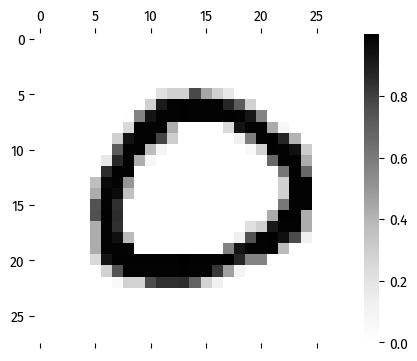

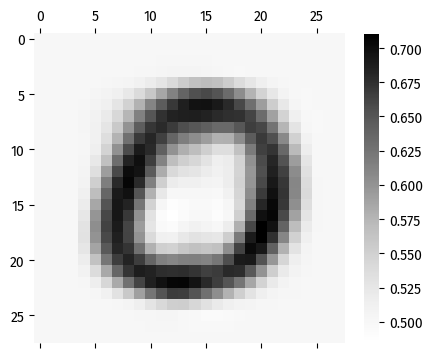

0.048203465 0.05039441
0.046070322 0.0504304
0.047659405 0.050432194
0.04799635 0.050418213
0.048037425 0.050418254
0.048845008 0.050389495
0.048633166 0.050408185
0.048787456 0.05041391
0.04743629 0.050465222
0.049448438 0.05044995
0.049484618 0.05043252
0.048360378 0.050385058
0.0485543 0.050395824
0.047136404 0.050447978
0.04801271 0.050440263
0.047975313 0.050435066
0.04765313 0.050387822
0.048087306 0.050424352
0.049421158 0.050420653
0.049032934 0.05040218
0.04862576 0.05040089
0.04906635 0.050397053
0.049371094 0.050415933
0.048899595 0.050411247
0.04796615 0.050411075
0.048338953 0.050368693
0.047999598 0.050372344
0.04807041 0.050405737
0.048017178 0.050392542
0.04831375 0.050364565
0.048725635 0.050391342
0.049973723 0.050404612
0.047983747 0.050408036
0.04945278 0.050401673
0.047619462 0.05039291
0.04828642 0.050418258
0.048946872 0.0504136
0.04767318 0.05044251
0.048922934 0.050417263
0.048636973 0.050469577
0.049003426 0.05041184
0.048386604 0.05041413
0.049751855 0.050400

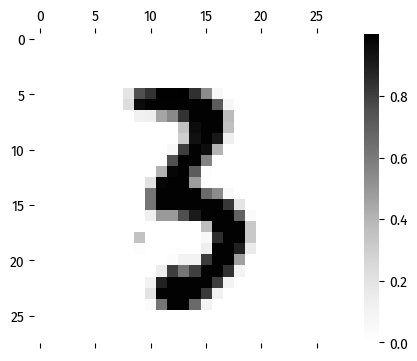

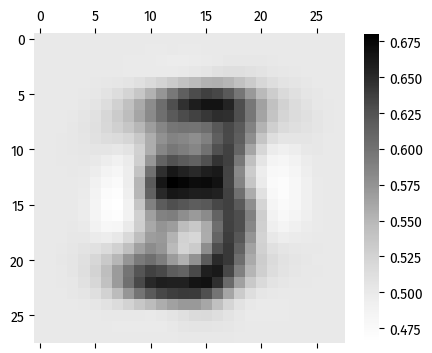

0.048203133 0.050415795
0.046249457 0.05042736
0.047028232 0.0504342
0.04847571 0.050428484
0.048162423 0.05040347
0.048581406 0.05040239
0.04739991 0.050472062
0.048647154 0.050407037
0.04852926 0.050383758
0.04746469 0.050414905
0.04898905 0.050423566
0.048727073 0.050405066
0.047830395 0.050447997
0.048317455 0.050412126
0.049196955 0.050465677
0.048814747 0.05042834
0.047954455 0.050466534
0.048170455 0.050425485
0.04840225 0.050446395
0.0482251 0.050462067
0.047898773 0.05043762
0.04793045 0.050417
0.04959161 0.050446264
0.048522692 0.050430577
0.049201023 0.05047578
0.048941344 0.05042478
0.047741957 0.050435767
0.04830181 0.0504114
0.047440454 0.05042404
0.048880603 0.050488736
0.048428986 0.050489407
0.04876452 0.050424084
0.048639327 0.050408386
0.048011243 0.050427187
0.048386358 0.05045158
0.048077933 0.050430395
0.047578625 0.050404623
0.048635762 0.050429784
0.049360145 0.050417773
0.04652555 0.05039989
0.04824213 0.05049705
0.048394926 0.050418217
0.04805776 0.050432745
0

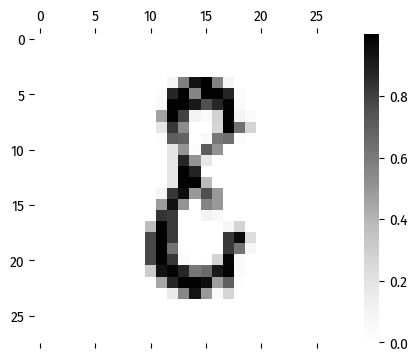

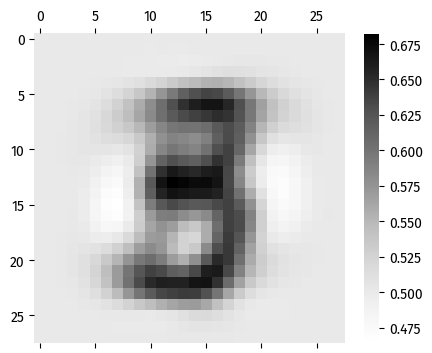

0.05076863 0.05042274
0.04827376 0.05042473
0.049030468 0.05040584
0.047701485 0.05043117
0.048242345 0.050429687
0.049204078 0.050423462
0.04854213 0.0504189
0.04860545 0.050434373
0.049030457 0.05044554
0.048368566 0.05042228
0.049357805 0.05045407
0.048252653 0.050420452
0.04720746 0.050409477
0.04809332 0.050409675
0.048360385 0.05040345
0.049750473 0.050438274
0.048352644 0.050490655
0.04879292 0.050443314
0.04827396 0.05045938
0.04847409 0.050417677
0.047704726 0.050434638
0.04878536 0.05043391
0.04864505 0.050420567
0.04772589 0.0504305
0.048584174 0.050452974
0.047776245 0.050403308
0.049071986 0.050482694
0.047577847 0.050439898
0.04809474 0.050457425
0.04868288 0.050407592
0.047849823 0.050435297
0.04880592 0.050447013
0.048461862 0.050433822
0.047791086 0.050449092
0.04780225 0.05044711
0.048335582 0.050439175
0.048287332 0.05046965
0.046912793 0.050493833
0.048455708 0.050468076
0.04878439 0.050419677
0.048293673 0.05047293
0.04951813 0.050485026
0.04900244 0.050495148
0.04

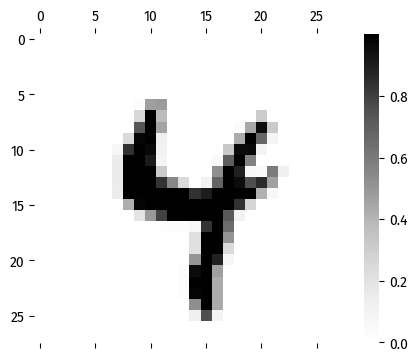

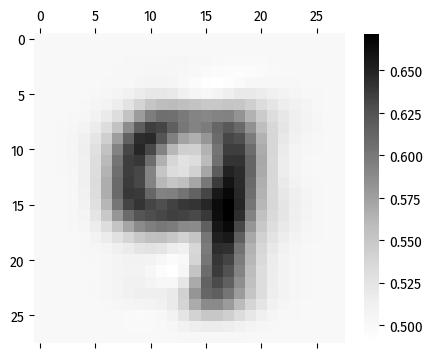

0.049494058 0.050422467
0.04988929 0.05045594
0.04633512 0.050461214
0.04852657 0.050432555
0.048040185 0.050430175
0.049027562 0.050444085
0.04845477 0.050422892
0.049559616 0.050451975
0.048623376 0.050423026
0.048042245 0.050431553
0.04721003 0.050443597
0.046844877 0.050453916
0.0488411 0.05045861
0.049030546 0.0504414
0.04964528 0.050476585
0.048662238 0.05042318
0.04754177 0.05043047
0.046935126 0.05043941
0.048968002 0.050427027
0.04792715 0.05044447
0.04804606 0.050439026
0.049168974 0.050410002
0.05070952 0.05045645
0.048156302 0.050458618
0.04950184 0.05043112
0.048735693 0.05047124
0.0487117 0.050485674
0.048982862 0.050417136
0.04771492 0.050427534
0.049337115 0.050437775
0.047853917 0.050420273
0.0488786 0.05043453
0.04889784 0.0504325
0.047965102 0.050414205
0.047858283 0.05044218
0.04697532 0.050437003
0.04889494 0.050414097
0.048363447 0.05047435
0.04833966 0.050432038
0.048277307 0.050454624
0.047092356 0.050448168
0.049737584 0.050443273
0.04805554 0.050429378
0.04738

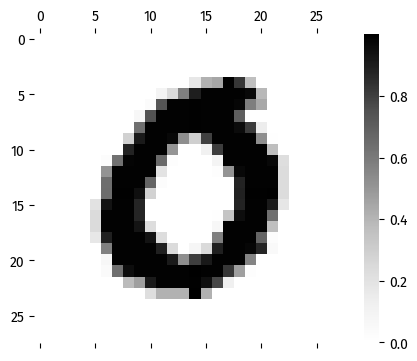

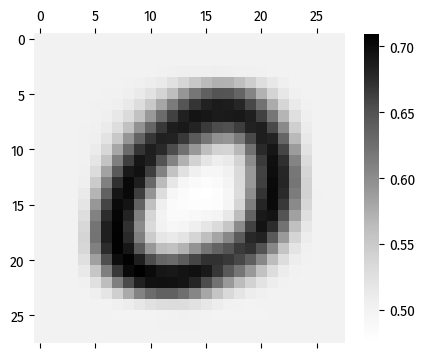

0.048370928 0.050428342
0.0498904 0.050418343
0.04887829 0.050465032
0.047186024 0.050437346
0.049200643 0.0504699
0.048680253 0.050417222
0.04897479 0.050442882
0.047982886 0.050443992
0.048032686 0.050438795
0.048566245 0.05042499
0.048186176 0.050437473
0.04765037 0.050460465
0.048809648 0.05042755
0.049154416 0.050482042
0.04999304 0.050439343
0.048078932 0.0504424
0.04772263 0.050438706
0.047394328 0.050446972
0.047511697 0.05050189
0.048116058 0.05045639
0.04828068 0.050438065
0.049087465 0.050454576
0.049468093 0.05047752
0.04791251 0.050486676
0.04697445 0.050424516
0.04928597 0.050463468
0.048491307 0.05043686
0.049353376 0.050469425
0.04899079 0.050457392
0.049489126 0.05042069
0.047655895 0.050445996
0.048870474 0.050463922
0.047672227 0.050439768
0.048087675 0.050438464
0.047665134 0.050456446
0.047726624 0.05048729
0.04788436 0.050455265
0.049691662 0.05042547
0.049855888 0.050431743
0.04832113 0.05045311
0.048445366 0.05048513
0.04879842 0.050447345
0.04855895 0.050533395

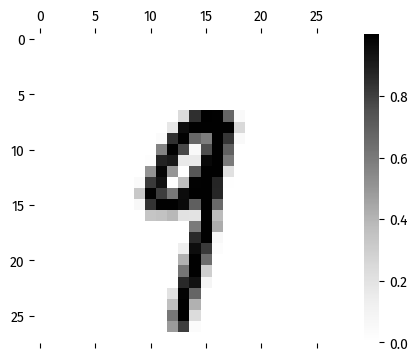

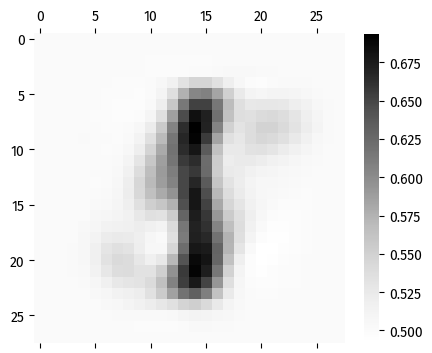

0.049528383 0.05042506
0.04797492 0.050460026
0.048316166 0.05044224
0.04906939 0.05041771
0.04861266 0.050463952
0.04850213 0.050464343
0.04906537 0.05051627
0.048668094 0.05044401
0.04848869 0.050494205
0.048235983 0.050488558
0.04869076 0.050522245
0.04625076 0.05045888
0.04789498 0.05047766
0.04856064 0.050499853
0.046977732 0.050485194
0.0476313 0.05047301
0.049384765 0.050460123
0.04778501 0.050521612
0.049024604 0.05048426
0.049985636 0.05045773
0.046797097 0.050499655
0.048750766 0.050464336
0.0488782 0.05046998
0.04940501 0.050485607
0.04769786 0.050439354
0.048978414 0.050500877
0.047981195 0.05047387
0.04979014 0.05044896
0.04776997 0.05048268
0.048981227 0.05047972
0.048325773 0.05047702
0.04885327 0.05050319
0.049482405 0.050526097
0.049352806 0.050485518
0.049997684 0.05046215
0.04810483 0.050466277
0.048779428 0.05048232
0.048342884 0.050465953
0.047448974 0.050464474
0.04990021 0.05046686
0.048688382 0.05043308
0.04926322 0.050451025
0.047778714 0.050466284
0.049477912 

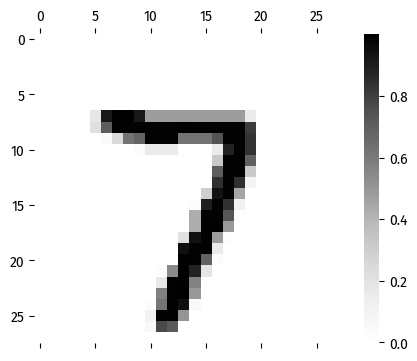

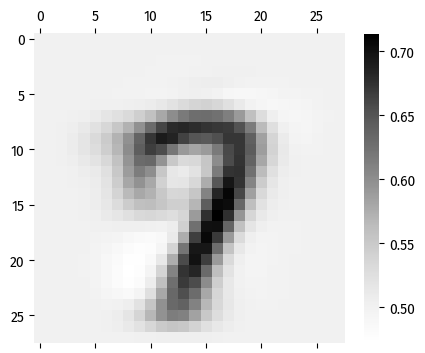

0.04726713 0.050481964
0.04849366 0.050504576
0.048834156 0.05047083
0.04895 0.05048537
0.047966037 0.0504808
0.048830327 0.050483722
0.047966596 0.05046373
0.04817716 0.05047359
0.04882183 0.050490346
0.047527302 0.050518107
0.0476882 0.05048799
0.048297994 0.050464507
0.047366392 0.050491966
0.04814858 0.05046279
0.04908044 0.05049054
0.048952248 0.05044815
0.04840809 0.05045882
0.048321962 0.05050279
0.047926717 0.050454304
0.048839297 0.050487272
0.048800554 0.050492853
0.047907904 0.05043048
0.047293197 0.05047993
0.04799579 0.050443877
0.047530476 0.05048065
0.048018344 0.05049074
0.04829952 0.050449215
0.047613747 0.050492655
0.047002327 0.05046421
0.047684662 0.05049424
0.04901668 0.050490674
0.04843993 0.050477006
0.04870874 0.050443456
0.04841982 0.050502617
0.048358813 0.050467253
0.048430264 0.050452
0.047890306 0.050498053
0.04855746 0.05046316
0.048999686 0.050473142
0.04722277 0.05047878
0.049316622 0.050467048
0.048923634 0.050479352
0.04949145 0.05048882
0.048759744 0.

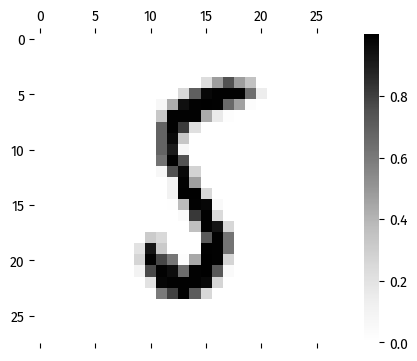

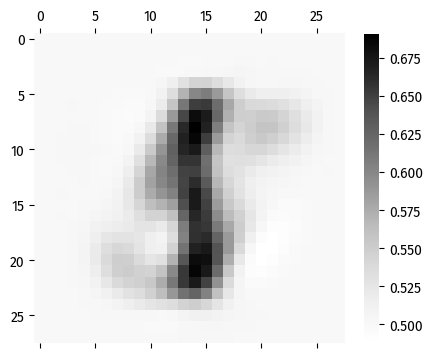

0.048621647 0.05047952
0.04793235 0.050515268
0.048195876 0.050434936
0.048619628 0.05049405
0.04738245 0.05046945
0.048852123 0.050505254
0.048421644 0.050505236
0.048186064 0.050480634
0.048782855 0.050474573
0.048386365 0.050475873
0.048979864 0.05052969
0.049126692 0.05047844
0.048377816 0.050489184
0.049341727 0.050448198
0.04727302 0.050471783
0.04939177 0.050484207
0.04833103 0.050470505
0.048232965 0.050480884
0.049543068 0.050484482
0.050101355 0.050460797
0.049086004 0.050452355
0.04842557 0.05050192
0.048514295 0.050488904
0.04900058 0.050485026
0.048122592 0.050496653
0.04884614 0.050487395
0.04865408 0.050484966
0.0480953 0.050480977
0.04767859 0.050500065
0.04841639 0.050478186
0.048509207 0.05046976
0.048780594 0.05048499
0.04781246 0.05050216
0.04674901 0.05047991
0.049229868 0.050460815
0.048305657 0.0505106
0.0492077 0.050513394
0.048722282 0.050523944
0.048757166 0.050485596
0.048385546 0.050490722
0.049382944 0.05049343
0.047922716 0.050510935
0.049153455 0.05049611

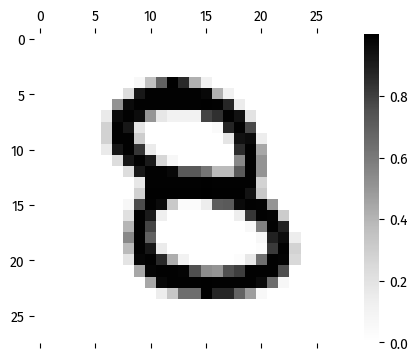

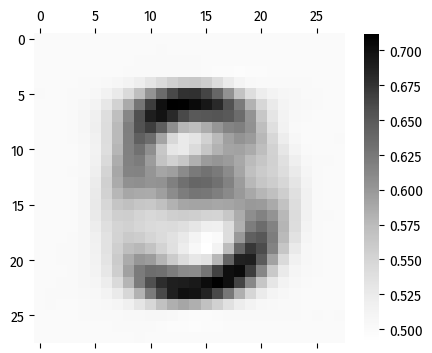

0.048710153 0.050510094
0.047865413 0.05056449
0.050068423 0.050479148
0.04893322 0.05048646
0.048445877 0.050448794
0.048615955 0.05050324
0.047784276 0.0504797
0.048427295 0.05054067
0.049090475 0.05047877
0.04644573 0.05051101
0.04811444 0.050496515
0.048728466 0.05048922
0.048112422 0.050478995
0.047951303 0.05051544
0.0478375 0.050468963
0.049179472 0.05049376
0.048174676 0.050514538
0.048874486 0.050490517
0.049519718 0.050499674
0.049269877 0.050513893
0.048221543 0.050490636
0.04955574 0.05051798
0.048660398 0.0504653
0.04892922 0.050479136
0.048865426 0.050495524
0.048523188 0.050504044
0.047942746 0.05048356
0.048516992 0.050490428
0.049459808 0.05045772
0.048462585 0.050519962
0.048762813 0.050502043
0.048357956 0.050495755
0.047320627 0.05047962
0.04893385 0.050515607
0.049381196 0.050445817
0.048895147 0.050467897
0.04915365 0.050506145
0.048325777 0.05048081
0.04932445 0.050485246
0.047613144 0.050495476
0.048971154 0.05050204
0.047662795 0.050539352
0.048280783 0.0504648

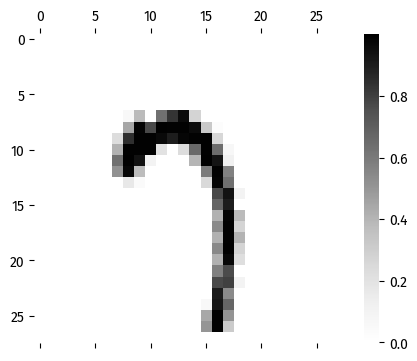

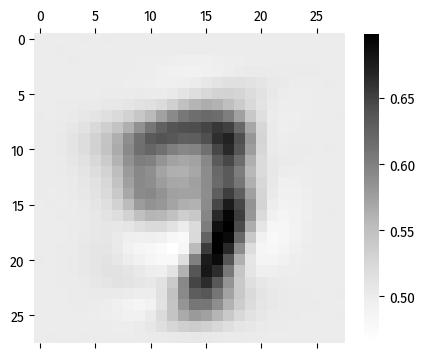

0.048515126 0.050480627
0.04945817 0.05051489
0.048297506 0.050492216
0.047937162 0.050489604
0.050131276 0.050500493
0.04868605 0.050560948
0.049392797 0.050499756
0.04831218 0.05052924
0.04749275 0.05048207
0.047356788 0.0504826
0.04916895 0.050474018
0.049552064 0.050480194
0.04872261 0.050503194
0.0480168 0.050495524
0.04856628 0.050462827
0.050096303 0.050500043
0.047487907 0.0505004
0.047987014 0.0505219
0.048157476 0.050509453
0.04787919 0.050470065
0.048291054 0.050523818
0.048069343 0.050484005
0.04824339 0.050513007
0.04871548 0.050558835
0.04834602 0.050511524
0.04893208 0.050482187
0.049825862 0.050527673
0.048588235 0.05050844
0.05019263 0.050496764
0.0481383 0.050499193
0.04864619 0.05054347
0.048374694 0.05054178
0.04872559 0.050515227
0.046800137 0.050527886
0.047691494 0.050524317
0.049568113 0.05048798
0.04881636 0.05053618
0.04686734 0.05051928
0.048502486 0.050498772
0.048825804 0.05047773
0.047786154 0.05054753
0.04706382 0.050576188
0.049944505 0.05051003
0.049014

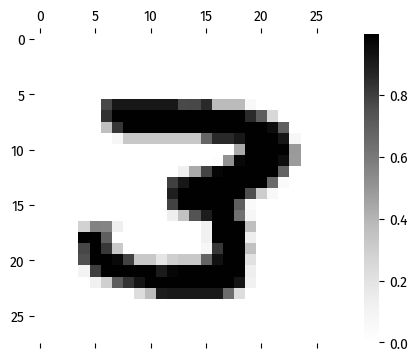

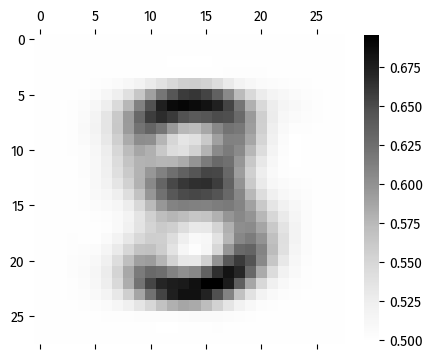

0.048485983 0.050495476
0.048117187 0.05049564
0.048549525 0.050540656
0.048288893 0.050507497
0.04940188 0.050498463
0.04864157 0.050514806
0.0482261 0.050525926
0.04941155 0.05050775
0.047871917 0.050497264
0.047143042 0.050497506
0.05023744 0.050507575
0.049484145 0.05046686
0.04858069 0.050527457
0.049228713 0.05055025
0.04717195 0.05052108
0.049368776 0.050509166
0.0488604 0.050487164
0.048346944 0.050509967
0.04782071 0.050506357
0.04707689 0.050473716
0.049107026 0.050503813
0.048672624 0.050526556
0.04885582 0.050507545
0.04898157 0.05048863
0.048739925 0.05051231
0.048765853 0.050506122
0.050207064 0.05050236
0.049068436 0.05051775
0.049655277 0.050515104
0.048806634 0.050538436
0.04800961 0.050568067
0.04846263 0.05050882
0.047353316 0.050530847
0.050603997 0.050533984
0.04793146 0.050534427
0.048708096 0.05054047
0.049156256 0.05056212
0.048948765 0.050523862
0.04807783 0.05051592
0.048003867 0.050505515
0.04899314 0.05051368
0.050212465 0.050514452
0.04856296 0.050563157
0.

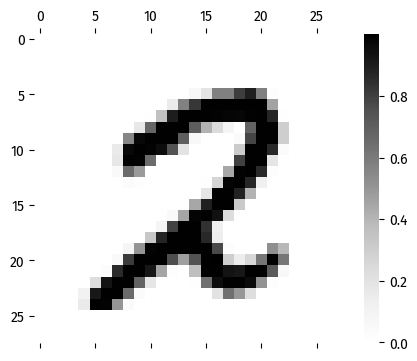

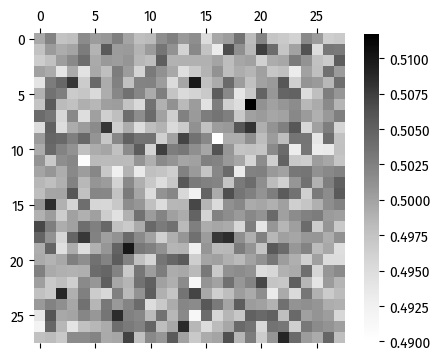

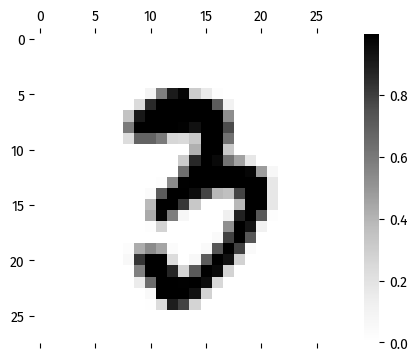

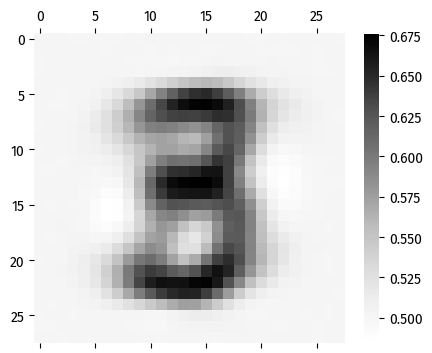

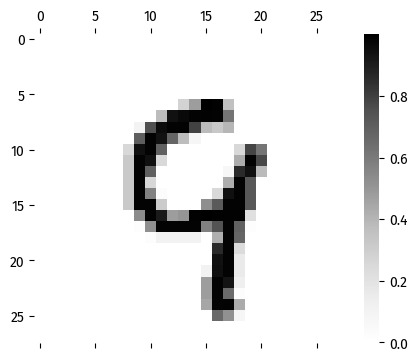

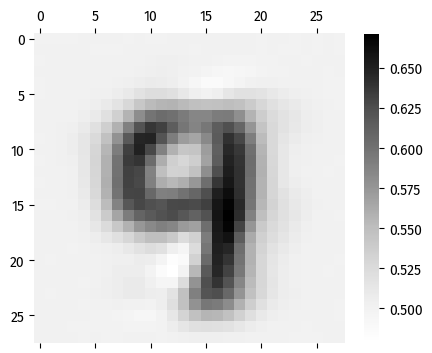

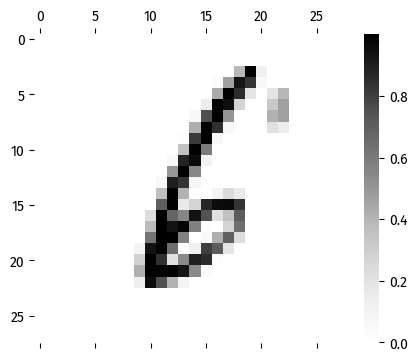

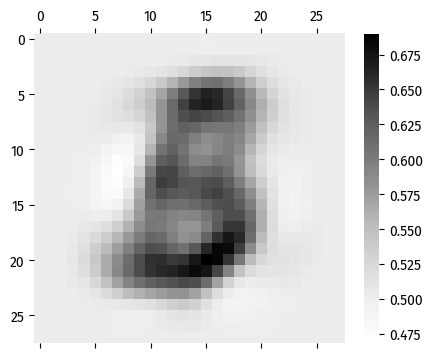

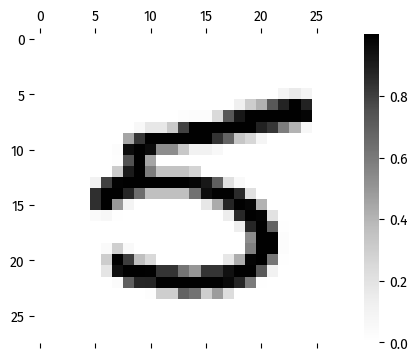

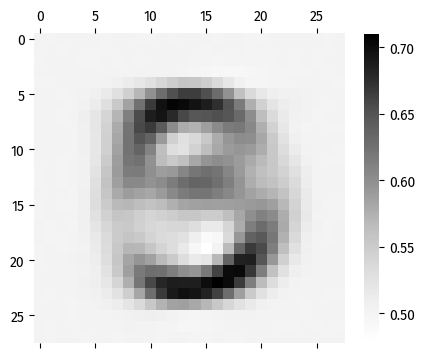

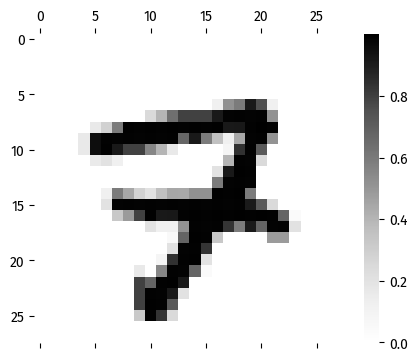

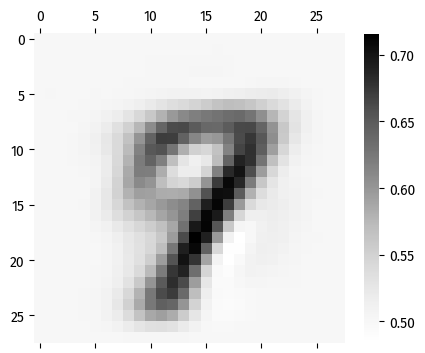

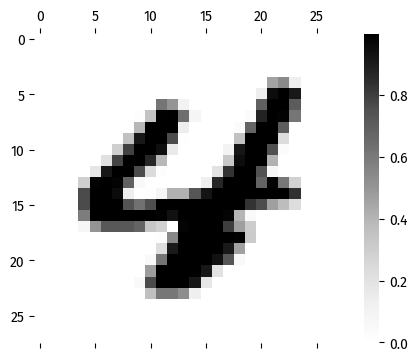

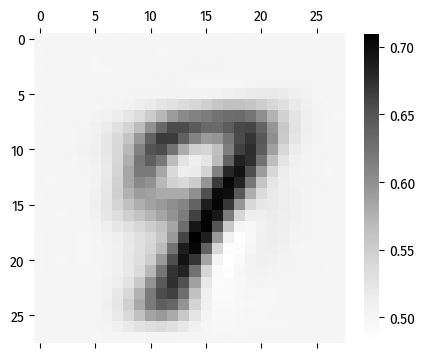

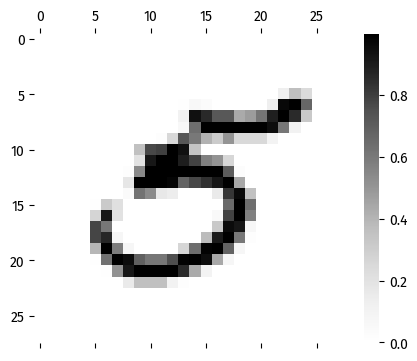

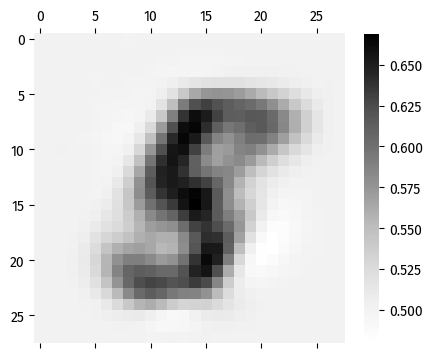

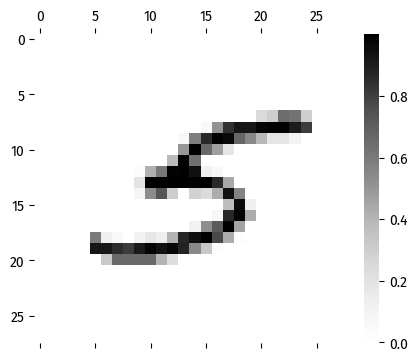

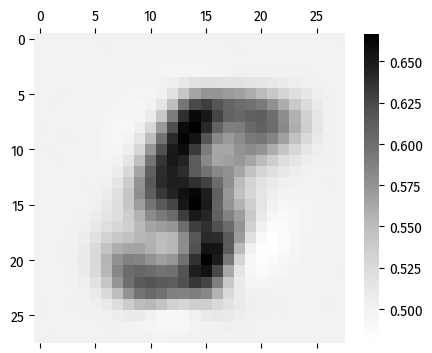

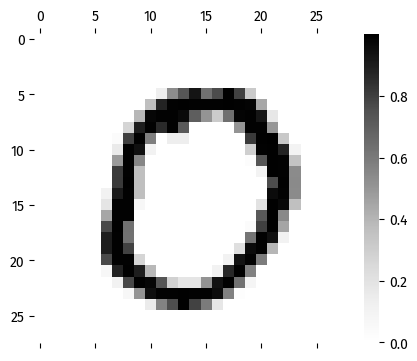

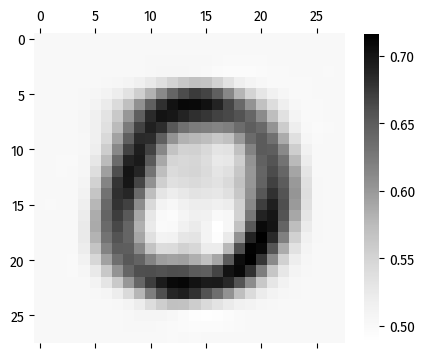

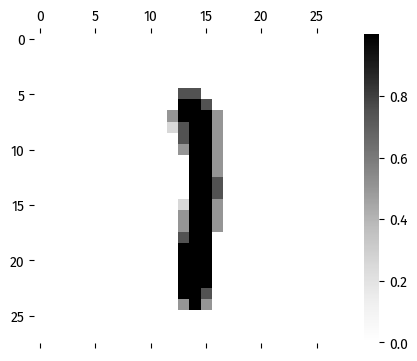

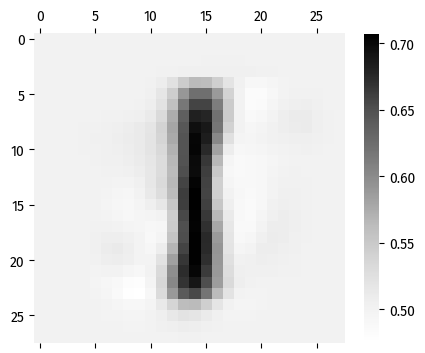

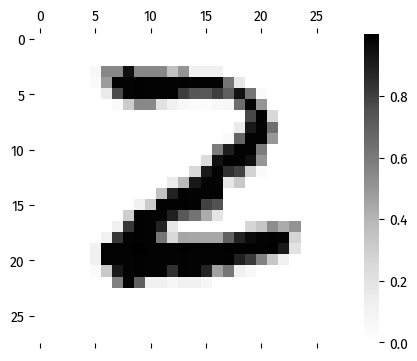

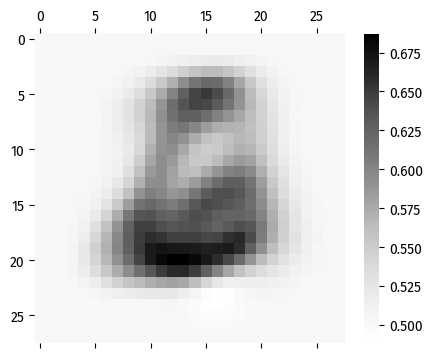

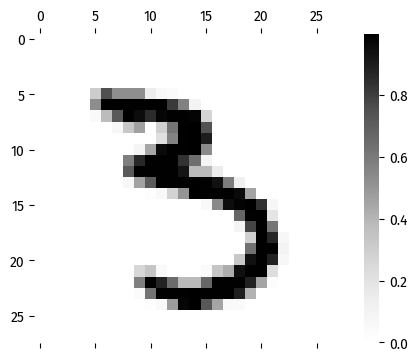

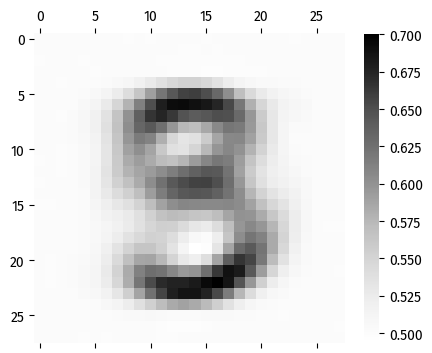

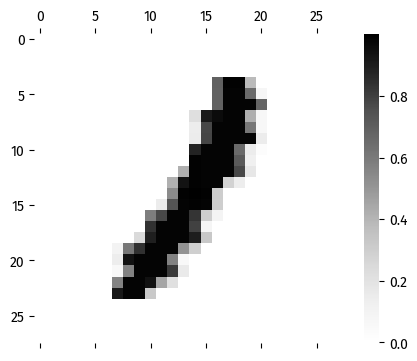

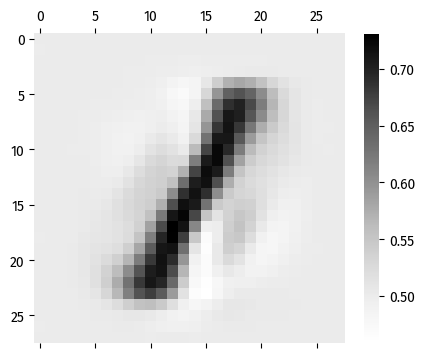

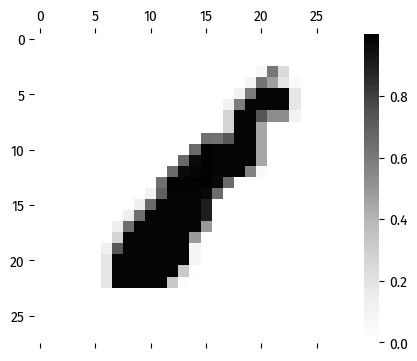

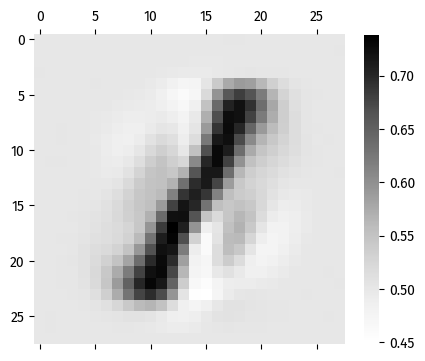

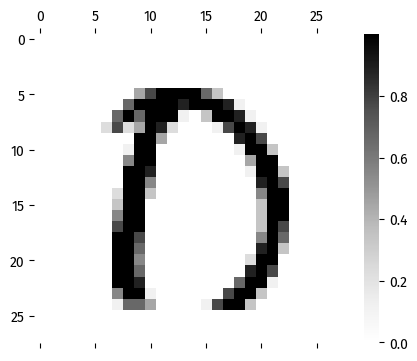

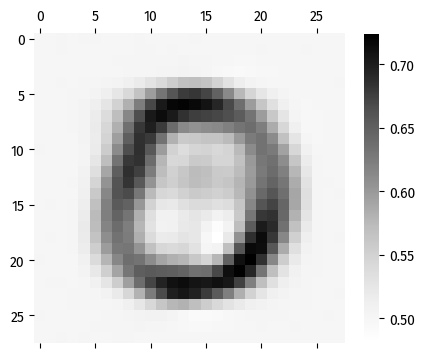

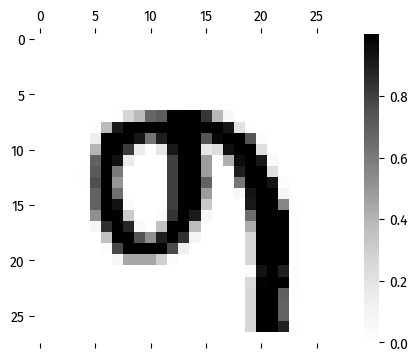

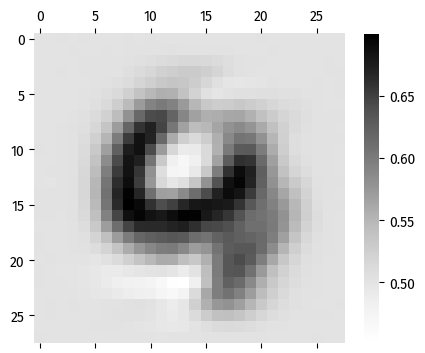

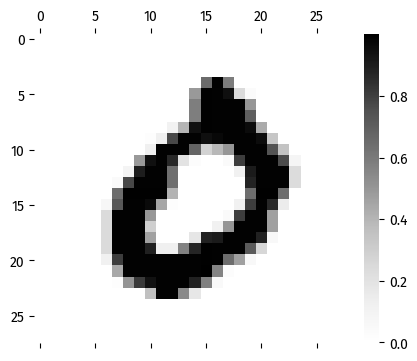

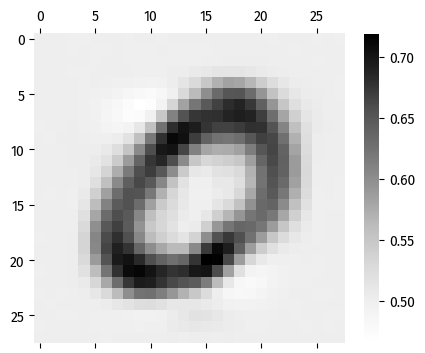

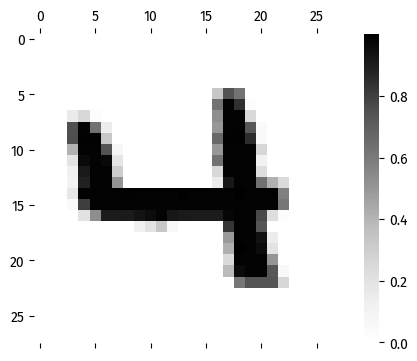

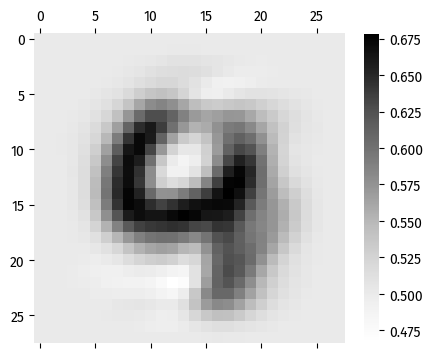

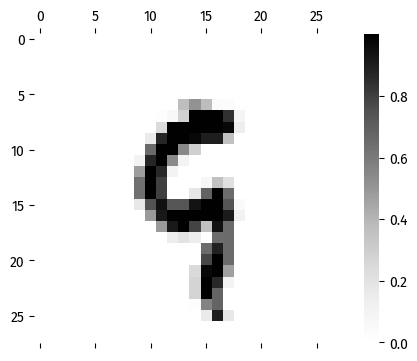

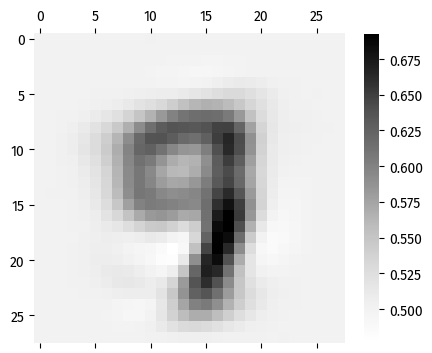

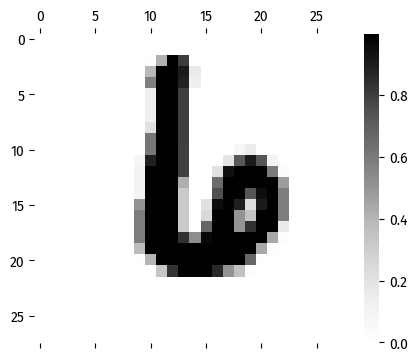

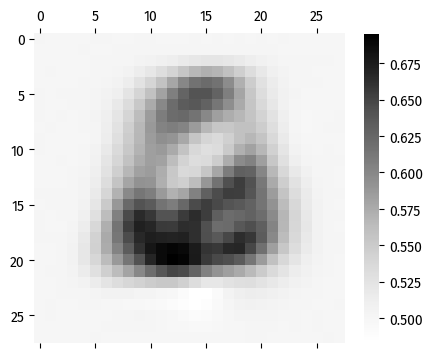

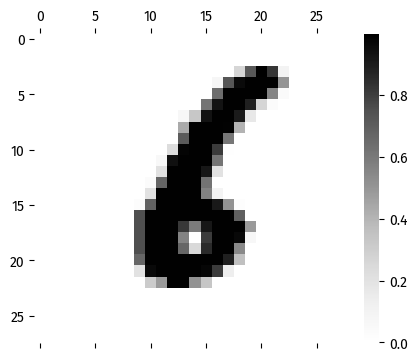

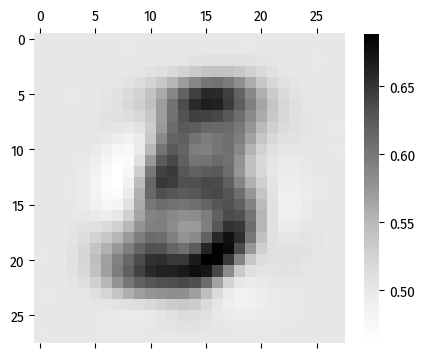

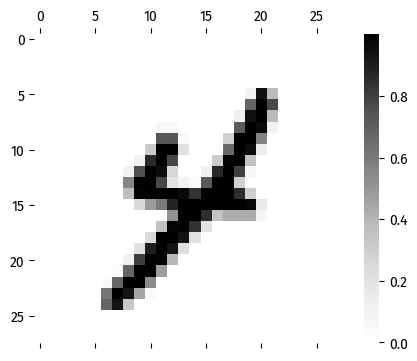

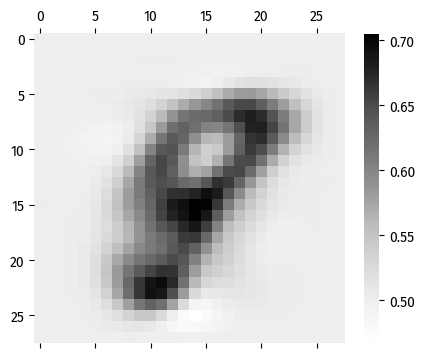

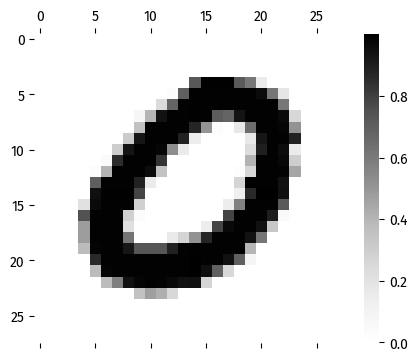

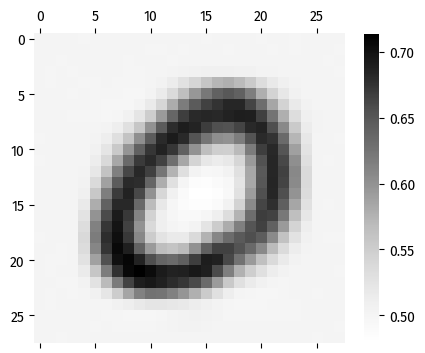

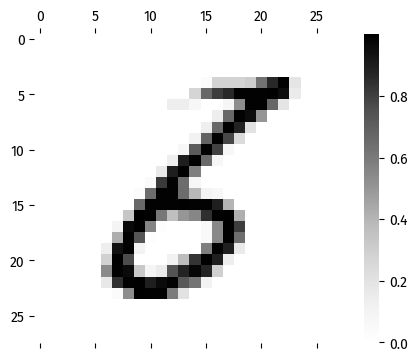

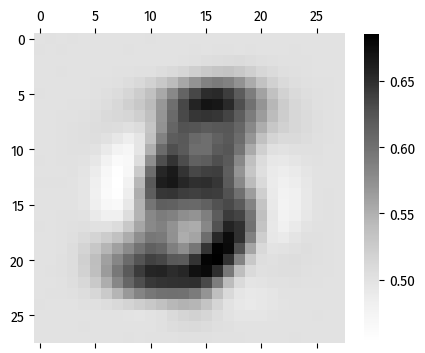

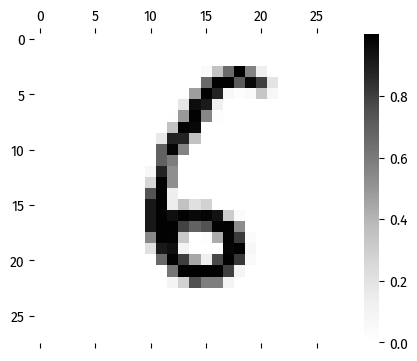

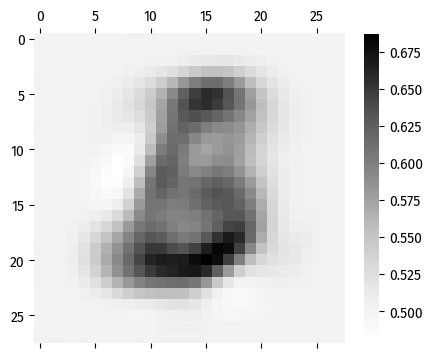

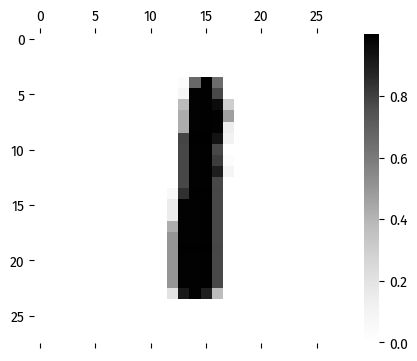

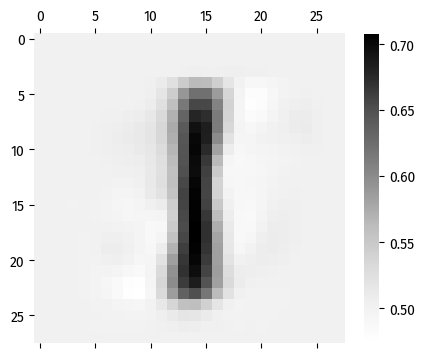

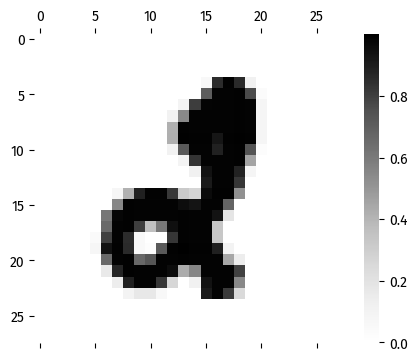

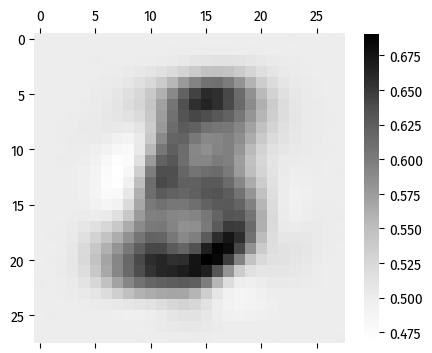

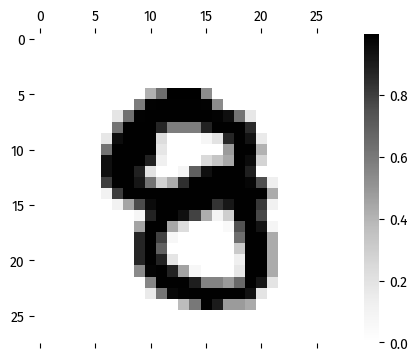

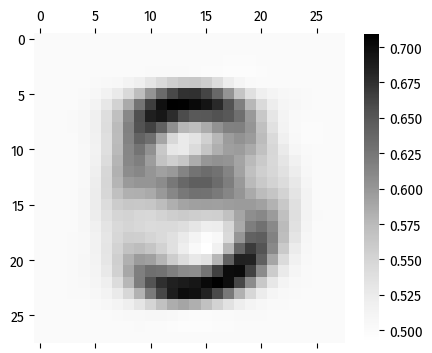

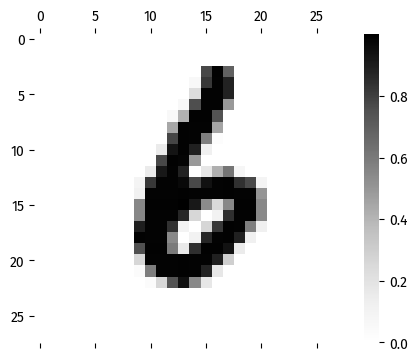

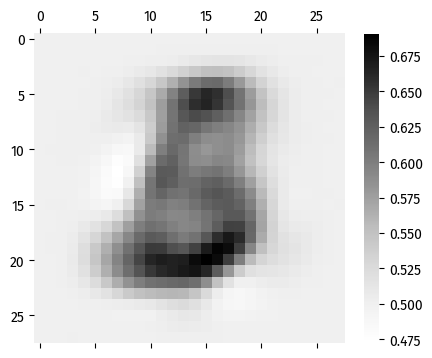

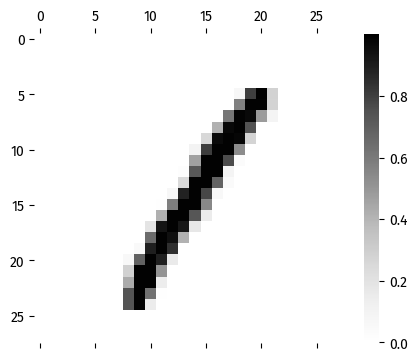

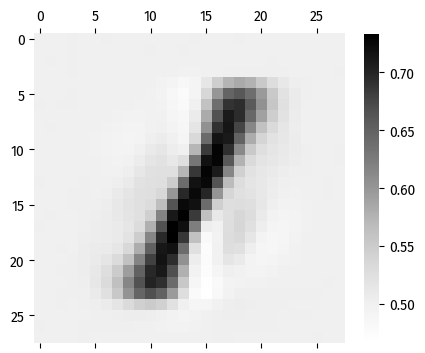

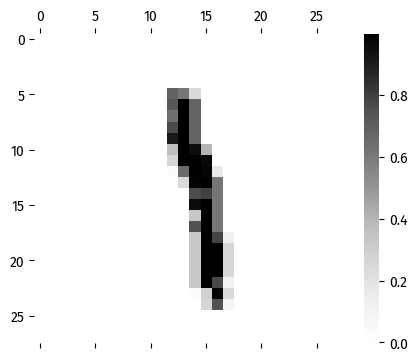

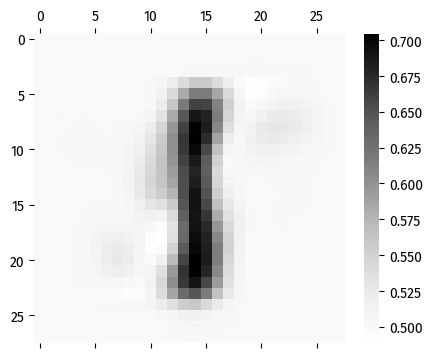

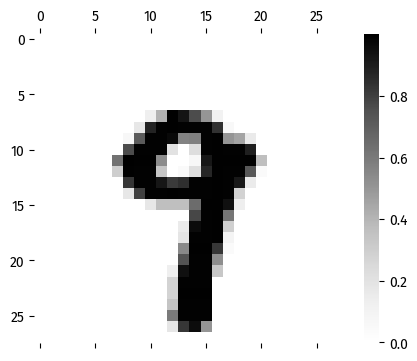

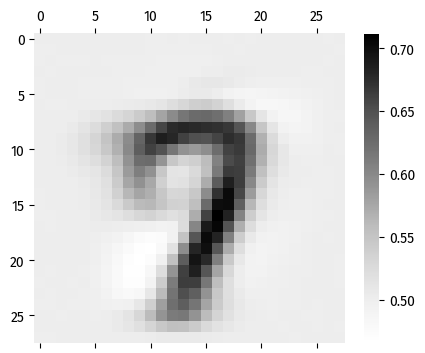

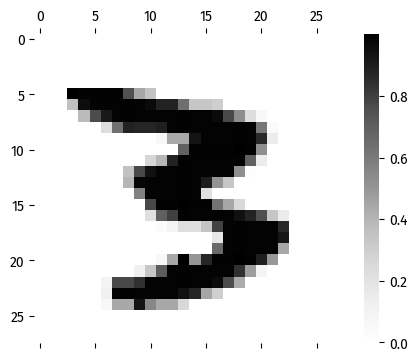

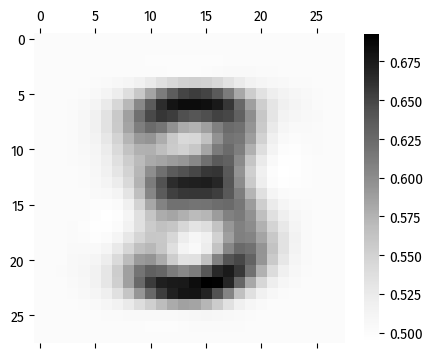

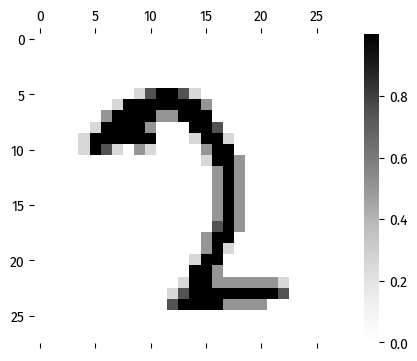

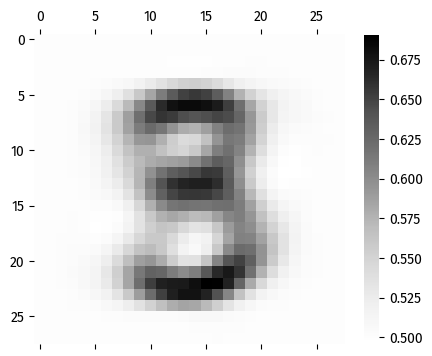

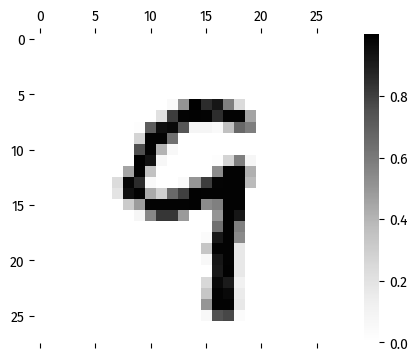

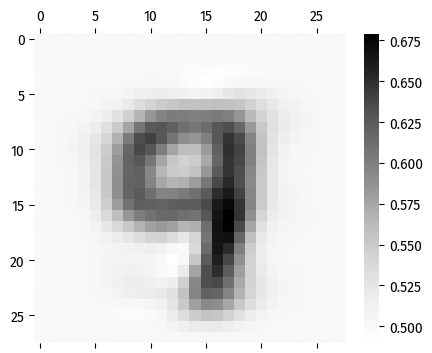

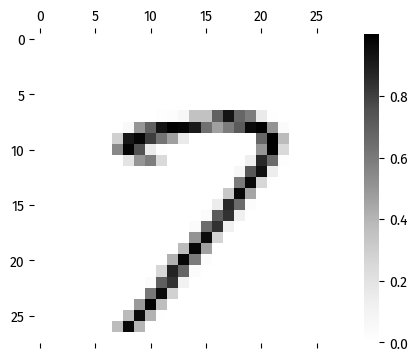

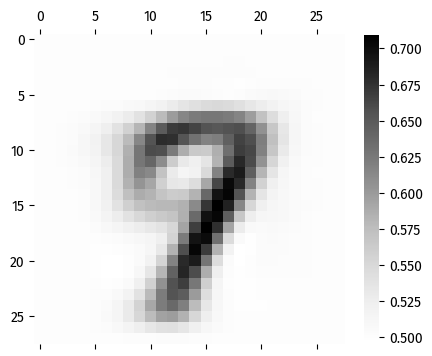

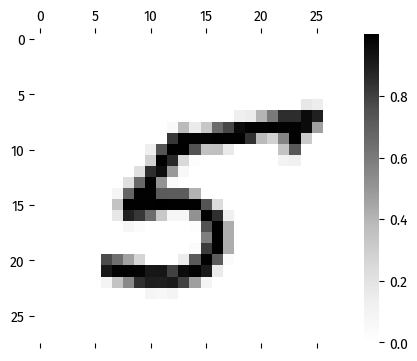

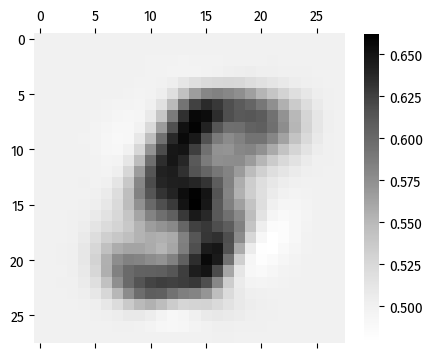

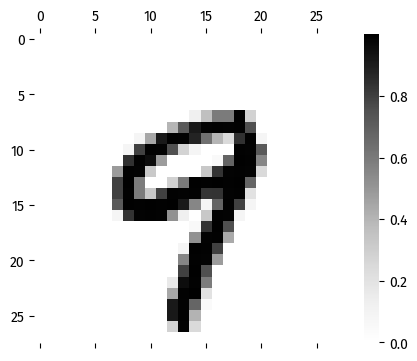

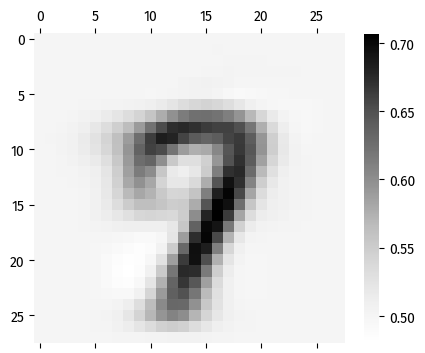

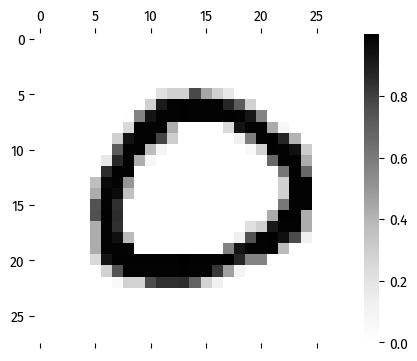

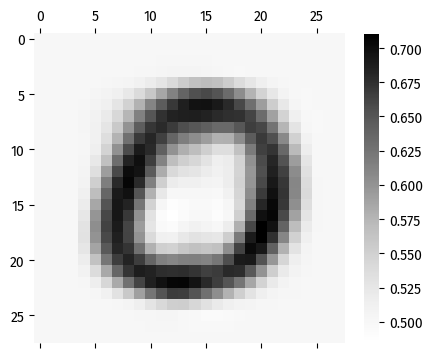

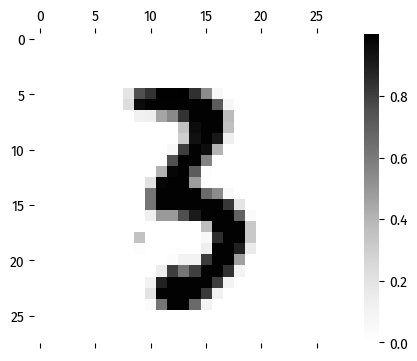

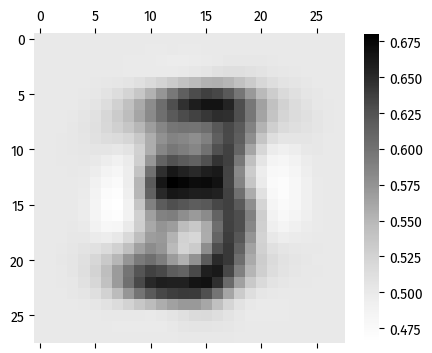

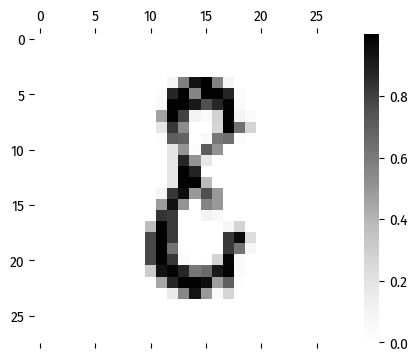

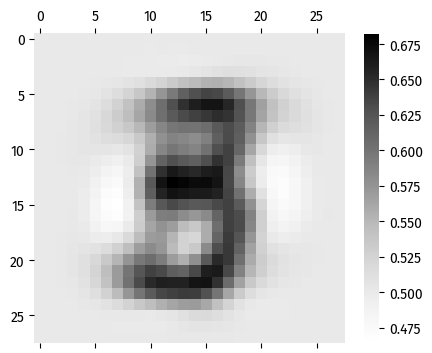

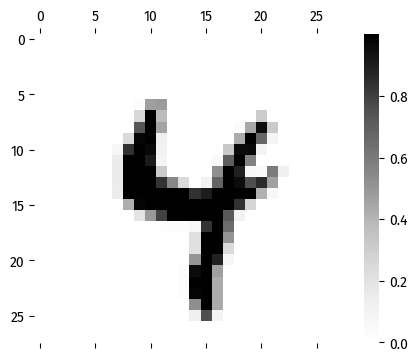

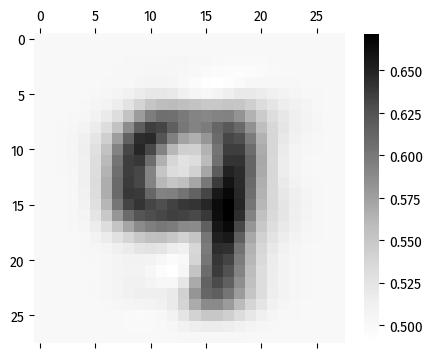

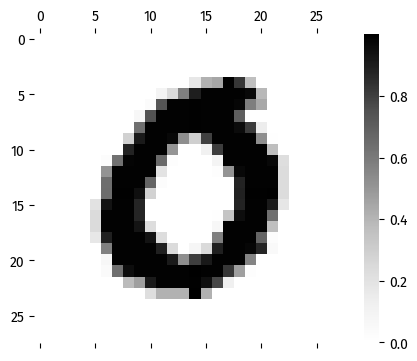

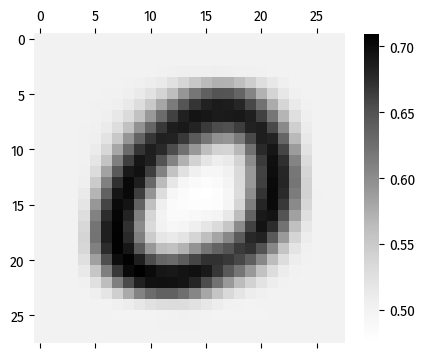

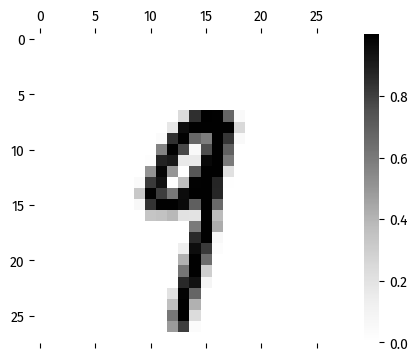

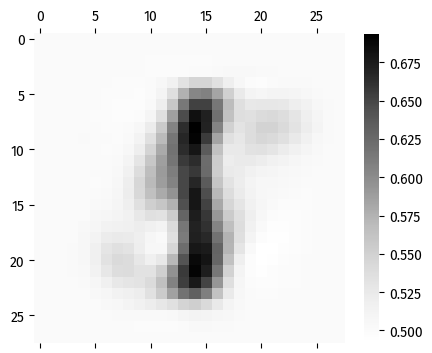

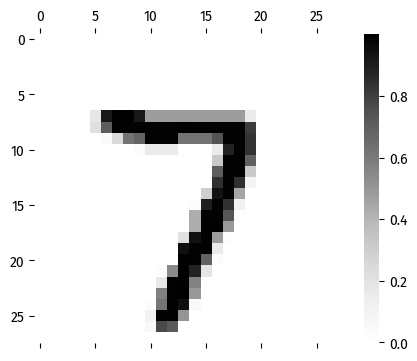

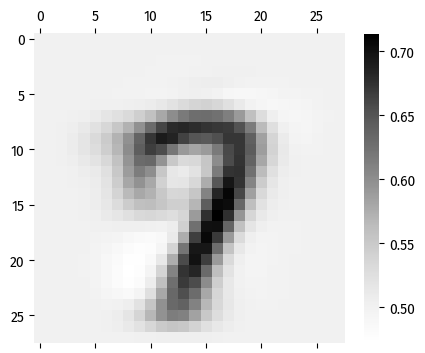

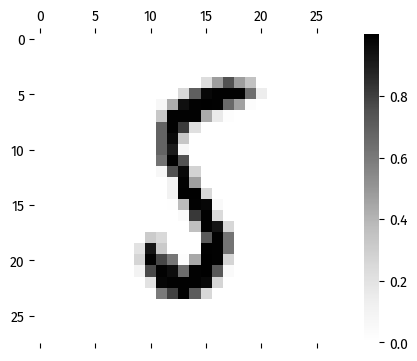

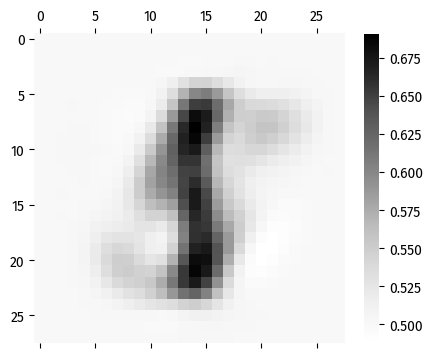

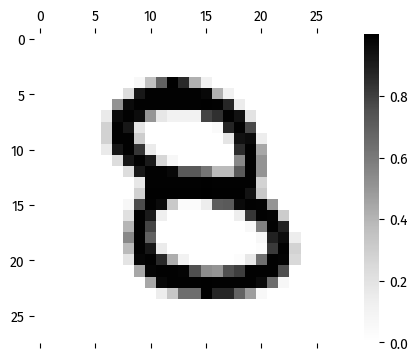

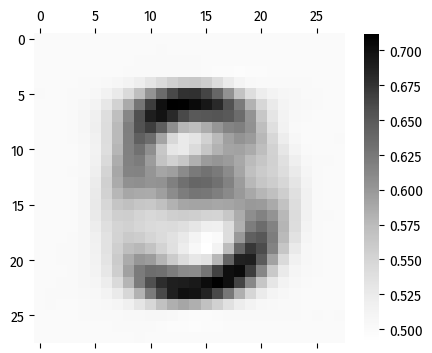

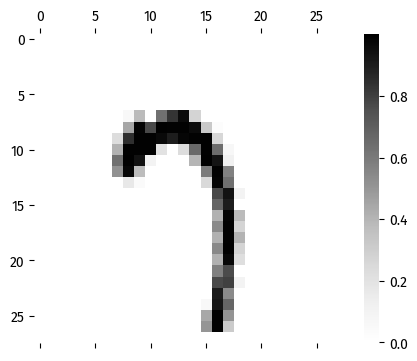

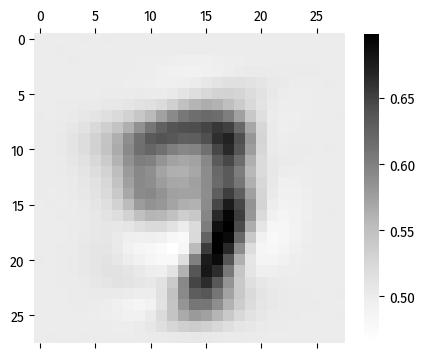

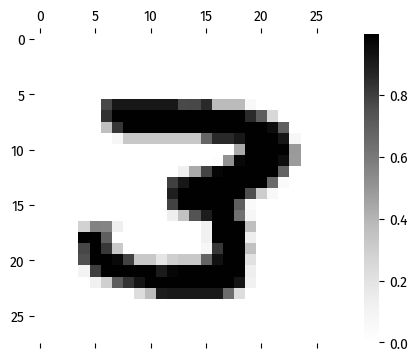

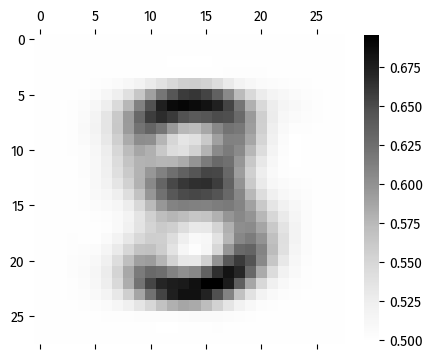

In [46]:
from plot_utils import visualize_matrix
from IPython.display import display
import math, random
import jax.numpy as np


loss_dt = loss_b.f(_, X_test)
loss_b_dt = loss_dt >> mean


batch_size = 512

def sample():
    return X[random.sample(range(n_samples), batch_size), :]

for i in range(500000):
    key = next(key_gen)
    data = sample()
    W, state = update(W, data, state)
    if i % 200 == 0:
        print(loss_bm(W, data), loss_b_dt(W))
    if i % 10000 == 0:
        image_id = math.ceil(random.uniform(0, 1) * n_samples)
        plt, __, __ = visualize_matrix(data[image_id, :].reshape(28, 28), dpi=100)
        display(plt)
        out = ae_b(W, data)
        plt, __, __ = visualize_matrix(out[image_id].reshape(28, 28), dpi=100)
        display(plt)

print(loss_b_dt(W))
